# Load libraries

In [1]:
library(dplyr)        ## for the R pipes
library(tidyr)        ## for tidying the dataframes
library(data.table)   ## load files into R faster
library(R.utils)      ## load .gz files within data.table::fread
library(ggplot2)      ## plotting package
library(cowplot)      ## plots + arrange plots etc
library(scales)       ## adding log scale to plots
library(RColorBrewer) ## color palettes
library(epitools)     ## OR and RR calculations
library(ggvenn)       ## plot venn digram
library(VennDiagram)  ## plot venn diagram
library(extrafont)    ## fonts for plots
library(ComplexUpset) ## generate upset plots
library(UpSetR)       ## generate upset plots
library(purrr)        ## functional programming
library(stringr)      ## for using string_detect


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.0 (2022-06-28 03:20:05 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘pac

# Summary of analysis

1. Bidirectional call summary
    
    a. Tfit calls
    
    b. dREG calls

    c. muMerge of calls

2. Summary overlaps of bidirectionals with enhancer databases

    a. Enhancer Atlas
    
    b. ENCODE
    
    c. FANTOM5
    
2. Significant GTEx eQTL variants overlap with bidirectionals

# Bidirectional call summary

## Metadata

In [2]:
metadata <- read.csv('/Users/rusi2317/projects/bidir_mumerge/condition_setup/20211026_db_output.csv')
dim(metadata)
head(metadata, 3)

[1] 2881   62

identifier      srp       srr        srz        replicate protocol organism  
1 Jiang2018multi  SRP133625 SRR6789175 SRR6789175 rep1      GRO-seq  H. sapiens
2 Jiang2018multi  SRP133625 SRR6789176 SRR6789176 rep2      GRO-seq  H. sapiens
3 Orioli2016human SRP064802 SRR2634645 SRR2634645 rep1      other    H. sapiens
  sample.type cell.type clone_individual ⋯ rseqc_five_utr rseqc_three_utr
1 cell line   HCT116                     ⋯ 13169755       1570971        
2 cell line   HCT116                     ⋯  8654825       2726810        
3 cell line   IMR90                      ⋯  3412166       3555460        
  rseqc_intron intron_rpk exint_ratio distinct_tenmillion_prop genome_prop_cov
1 13913192     10.35      4.005797    0.53434150               0.16168942     
2 25635316     19.07      3.274253    0.76100050               0.21792593     
3  1989643      1.48      2.020270    0.05481745               0.00798298     
  avg_fold_cov samp_qc_score samp_data_score
1 1.691249     2             2              
2 1.541681     1             2              
3 0.578256     4             5

In [3]:
tissues_celltypes <- read.csv('/Users/rusi2317/projects/meta_analysis_qc/hg38/metadata/human_cell_types.csv')
metadata_celltype <- merge(metadata, tissues_celltypes, by="cell.type", all=TRUE)
dim(metadata_celltype)
head(metadata_celltype, 3)

[1] 2881   67

cell.type identifier                 srp       srr        srz       
1 3T3-L1    Cardamone2018mitochondrial SRP074240 SRR6508250 SRR6508250
2 3T3-L1    Step2014antidiabetic       SRP041129 SRR1233867 SRR1233867
3 3T3-L1    Step2014antidiabetic       SRP041129 SRR1233868 SRR1233868
  replicate protocol organism    sample.type clone_individual ⋯
1 rep1      GRO-seq  M. musculus cell line                    ⋯
2 rep1      GRO-seq  M. musculus cell line                    ⋯
3 rep1      GRO-seq  M. musculus cell line                    ⋯
  distinct_tenmillion_prop genome_prop_cov avg_fold_cov samp_qc_score
1 0.3100634                0.04484703      0.7632561    4            
2 0.6086274                0.19943574      2.4468585    2            
3 0.6364656                0.21995844      2.6190025    2            
  samp_data_score tissue_type tissue_long_discription tissue disease notes.y
1 4               NA          NA                      NA     NA      NA     
2 2               NA          NA                      NA     NA      NA     
3 1               NA          NA                      NA     NA      NA

## Human annotations

In [4]:
hg38_chrom_sizes <- read.table('/scratch/Shares/dowell/genomes/hg38/hg38.chrom.sizes.unsorted')
hg38_chroms <- hg38_chrom_sizes[1:24,]
hg38_chroms$chrs <- factor(hg38_chroms$V1, levels = hg38_chroms$V1)
head(hg38_chroms, 3)

V1   V2        chrs
1 chr1 248956422 chr1
2 chr2 242193529 chr2
3 chr3 198295559 chr3

In [5]:
hg38_bidirs <- read.table("/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_qc4_gc50perc_tss50perc_MASTER_tfit_dreg.bed")
dim(hg38_bidirs)
head(hg38_bidirs, 3)

[1] 652281      4

V1   V2    V3    V4       
1 chr1  3729  7400 dreg     
2 chr1 10151 11371 tfit,dreg
3 chr1 12344 12712 dreg

In [6]:
hg38_refseq <- read.table('/scratch/Shares/dowell/genomes/hg38/hg38_refseq_genenames.bed')
hg38_refseq_chr <- hg38_refseq[hg38_refseq$V1 %in% hg38_chroms$V1,]
dim(hg38_refseq_chr)
dim(hg38_refseq)
head(hg38_refseq_chr, 3)

[1] 72337    12

[1] 82500    12

V1   V2    V3    V4                  V5 V6 V7    V8    V9 V10
1 chr1 11873 14409 NR_046018_DDX11L1   0  +  14409 14409 0   3 
2 chr1 14361 29370 NR_024540_WASH7P    0  -  29370 29370 0  11 
3 chr1 17368 17436 NR_106918_MIR6859-1 0  -  17436 17436 0   1 
  V11                                      
1 354,109,1189,                            
2 468,69,152,159,198,136,137,147,99,154,50,
3 68,                                      
  V12                                                  
1 0,739,1347,                                          
2 0,608,1434,2245,2496,2871,3244,3553,3906,10376,14959,
3 0,

## Mouse annotations

In [7]:
mm10_chrom_sizes <- read.table('/scratch/Shares/dowell/genomes/mm10/mm10.chrom.sizes')#hg38/hg38.chrom.sizes.unsorted')
mm10_chroms <- mm10_chrom_sizes[1:21,]
mm10_chroms$chrs <- factor(mm10_chroms$V1, levels = mm10_chroms$V1)
head(mm10_chroms,3)

V1   V2        chrs
1 chr1 195471971 chr1
2 chr2 182113224 chr2
3 chr3 160039680 chr3

In [8]:
mm10_bidirs <- read.table("/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/mm10_qc4_gc50perc_tss50perc_MASTER_tfit_dreg.bed")
dim(mm10_bidirs)
head(mm10_bidirs, 3)

[1] 563108      4

V1   V2   V3   V4  
1 chr1   35  417 dreg
2 chr1 1160 2910 dreg
3 chr1 3701 4600 dreg

In [9]:
mm10_refseq <- read.table('/scratch/Shares/dowell/genomes/mm10/mm10_refseq.bed')
mm10_refseq_chr <- mm10_refseq[mm10_refseq$V1 %in% mm10_chroms$V1,]
dim(mm10_refseq_chr)
dim(mm10_refseq)
head(mm10_refseq_chr, 3)

[1] 47248    12

[1] 47382    12

V1   V2        V3        V4           V5 V6 V7        V8        V9 V10
1 chr1 134199214 134235457 NM_001039510 0  -  134202950 134234355 0  3  
2 chr1 134199214 134235457 NM_001282945 0  -  134202950 134234355 0  3  
3 chr1 134199214 134235457 NM_001008533 0  -  134202950 134234355 0  2  
  V11           V12           
1 4376,398,230, 0,34800,36013,
2 4376,432,230, 0,34800,36013,
3 4376,1443,    0,34800,

## Bidirectionals per sample

In [10]:
dbnascent <- list.dirs(path = '/Shares/dbnascent',
          full.names = TRUE, 
          recursive = FALSE
             )

dbnascent_paths <- paste0(dbnascent, "/bidir_summary")
length(dbnascent_paths)

[1] 291

### Tfit


In [11]:
tfit_summary_paths <- unlist(lapply(dbnascent_paths, 
                              list.files, 
                              pattern="tfit_stats.txt",
                              full.names=TRUE))

length(dbnascent_paths)
length(tfit_summary_paths)

[1] 291

[1] 230

In [12]:
#load all summaries
tfit_summary <- lapply(tfit_summary_paths, 
                    data.table::fread) 

In [13]:
#combine summary tables to one
tfit_summary_dt <- do.call(rbind, tfit_summary)
dim(tfit_summary_dt)
head(tfit_summary_dt)

[1] 2147    6

sample_name num_tfit_bidir num_tfit_bidir_promoter num_tfit_bidir_intronic
1 SRR8364243  86645          15739                   24233                  
2 SRR8364244  73288          13813                   20856                  
3 SRR8364245  75885          15304                   20862                  
4 SRR8364246  82506          16147                   22624                  
5 SRR8364247  26869          10288                    6665                  
6 SRR8364248  54600          15006                   15417                  
  num_tfit_bidir_intergenic tfit_bidir_gc_prop
1 38243                     0.487             
2 30533                     0.489             
3 30915                     0.499             
4 34698                     0.497             
5  6339                     0.519             
6 18785                     0.511

#### Merge with metadata

In [14]:
tfit_summary_metadata <- merge(tfit_summary_dt, 
                               metadata_celltype, 
                               by.x="sample_name",
                               by.y="srz")
tfit_summary_metadata$bidir_caller <- 'Tfit'
dim(tfit_summary_metadata)
head(tfit_summary_metadata,3)

[1] 2147   73

sample_name num_tfit_bidir num_tfit_bidir_promoter num_tfit_bidir_intronic
1 ERR769522    9110           4417                   1969                   
2 ERR769523    9020           4395                   2172                   
3 ERR769524   26783          11047                   7190                   
  num_tfit_bidir_intergenic tfit_bidir_gc_prop cell.type identifier    
1 1225                      0.541              HeLa      Laitem2015cdk9
2 1192                      0.547              HeLa      Laitem2015cdk9
3 5662                      0.531              HeLa      Laitem2015cdk9
  srp       srr       ⋯ genome_prop_cov avg_fold_cov samp_qc_score
1 ERP009673 ERR769522 ⋯ 0.02302726      1.763895     3            
2 ERP009673 ERR769523 ⋯ 0.02839443      1.841769     3            
3 ERP009673 ERR769524 ⋯ 0.08074595      1.631553     2            
  samp_data_score tissue_type tissue_long_discription tissue disease notes.y
1 5               epithelial  Uterus; Cervix          Uterus                
2 5               epithelial  Uterus; Cervix          Uterus                
3 3               epithelial  Uterus; Cervix          Uterus                
  bidir_caller
1 Tfit        
2 Tfit        
3 Tfit

### dREG 

In [15]:
dreg_summary_paths <- unlist(lapply(dbnascent_paths, 
                              list.files, 
                              pattern="dreg_stats.txt",
                              full.names=TRUE))

length(dbnascent_paths)
length(dreg_summary_paths)

[1] 291

[1] 229

In [16]:
#load all summaries
dreg_summary <- lapply(dreg_summary_paths, 
                    data.table::fread) 

In [17]:
#combine summary tables to one
dreg_summary_dt <- do.call(rbind, dreg_summary)
dim(dreg_summary_dt)
head(dreg_summary_dt)

[1] 2143    6

sample_name num_dreg_bidir num_dreg_bidir_promoter num_dreg_bidir_intronic
1 SRR8364243  63678          14104                   17500                  
2 SRR8364244  51616          13378                   13512                  
3 SRR8364245  50841          14614                   12974                  
4 SRR8364246  57441          15028                   15155                  
5 SRR8364247  21882          12354                    4338                  
6 SRR8364248  39489          14466                   10659                  
  num_dreg_bidir_intergenic dreg_bidir_gc_prop
1 27710                     0.528             
2 21325                     0.538             
3 19773                     0.543             
4 23328                     0.538             
5  4685                     0.589             
6 12776                     0.558

#### Merge with metadata

In [18]:
dreg_summary_metadata <- merge(dreg_summary_dt, 
                               metadata_celltype, 
                               by.x="sample_name",
                               by.y="srz")
dreg_summary_metadata$bidir_caller <- 'dREG'

In [19]:
dim(dreg_summary_metadata)
head(dreg_summary_metadata)

[1] 2143   73

sample_name num_dreg_bidir num_dreg_bidir_promoter num_dreg_bidir_intronic
1 ERR769522    5444           4491                    509                   
2 ERR769523    5212           4293                    543                   
3 ERR769524   10868           7450                   1782                   
4 ERR769525    9257           7047                   1174                   
5 SRM497904   21063          10336                   4791                   
6 SRM497907   29387           9998                   8960                   
  num_dreg_bidir_intergenic dreg_bidir_gc_prop cell.type identifier     
1  612                      0.613              HeLa      Laitem2015cdk9 
2  557                      0.609              HeLa      Laitem2015cdk9 
3 2000                      0.584              HeLa      Laitem2015cdk9 
4 1494                      0.593              HeLa      Laitem2015cdk9 
5 4853                      0.585              MCF7      Hah2013enhancer
6 8299                      0.538              MCF7      Hah2013enhancer
  srp       srr       ⋯ genome_prop_cov avg_fold_cov samp_qc_score
1 ERP009673 ERR769522 ⋯ 0.02302726      1.7638952    3            
2 ERP009673 ERR769523 ⋯ 0.02839443      1.8417689    3            
3 ERP009673 ERR769524 ⋯ 0.08074595      1.6315529    2            
4 ERP009673 ERR769525 ⋯ 0.08041634      1.2510166    2            
5 SRP018256 SRR653421 ⋯ 0.05693220      0.5107155    3            
6 SRP018256 SRR653422 ⋯ 0.08370614      0.6843232    2            
  samp_data_score tissue_type tissue_long_discription tissue disease notes.y
1 5               epithelial  Uterus; Cervix          Uterus                
2 5               epithelial  Uterus; Cervix          Uterus                
3 3               epithelial  Uterus; Cervix          Uterus                
4 3               epithelial  Uterus; Cervix          Uterus                
5 4               epithelial  Breast; Mammary gland   Breast                
6 3               epithelial  Breast; Mammary gland   Breast                
  bidir_caller
1 dREG        
2 dREG        
3 dREG        
4 dREG        
5 dREG        
6 dREG

In [20]:
bidir_summary <- rbind(tfit_summary_metadata,
                       dreg_summary_metadata, use.names=FALSE)
dim(bidir_summary)
colnames(bidir_summary)
head(bidir_summary, 3)

[1] 4290   73

[1] "sample_name"               "num_tfit_bidir"           
 [3] "num_tfit_bidir_promoter"   "num_tfit_bidir_intronic"  
 [5] "num_tfit_bidir_intergenic" "tfit_bidir_gc_prop"       
 [7] "cell.type"                 "identifier"               
 [9] "srp"                       "srr"                      
[11] "replicate"                 "protocol"                 
[13] "organism"                  "sample.type"              
[15] "clone_individual"          "strain"                   
[17] "genotype"                  "construct"                
[19] "baseline_control_expt"     "treatment.type"           
[21] "treatment"                 "times"                    
[23] "timecourse"                "library.prep"             
[25] "spike.in"                  "notes.x"                  
[27] "experimentally.not.usable" "curator.1"                
[29] "curator.2"                 "published"                
[31] "bibtex"                    "author"                   
[33] "year"                      "last.author"              
[35] "doi"                       "single_paired"            
[37] "rcomp"                     "other.data"               
[39] "atac.seq"                  "rna.seq"                  
[41] "chip.seq"                  "three.d"                  
[43] "other.seq"                 "sample_id"                
[45] "sample_name.y"             "genetic_id"               
[47] "expt_id"                   "raw_read_depth"           
[49] "raw_read_length"           "trim_read_depth"          
[51] "duplication_picard"        "single_map"               
[53] "multi_map"                 "map_prop"                 
[55] "rseqc_tags"                "rseqc_cds"                
[57] "cds_rpk"                   "rseqc_five_utr"           
[59] "rseqc_three_utr"           "rseqc_intron"             
[61] "intron_rpk"                "exint_ratio"              
[63] "distinct_tenmillion_prop"  "genome_prop_cov"          
[65] "avg_fold_cov"              "samp_qc_score"            
[67] "samp_data_score"           "tissue_type"              
[69] "tissue_long_discription"   "tissue"                   
[71] "disease"                   "notes.y"                  
[73] "bidir_caller"

sample_name num_tfit_bidir num_tfit_bidir_promoter num_tfit_bidir_intronic
1 ERR769522    9110           4417                   1969                   
2 ERR769523    9020           4395                   2172                   
3 ERR769524   26783          11047                   7190                   
  num_tfit_bidir_intergenic tfit_bidir_gc_prop cell.type identifier    
1 1225                      0.541              HeLa      Laitem2015cdk9
2 1192                      0.547              HeLa      Laitem2015cdk9
3 5662                      0.531              HeLa      Laitem2015cdk9
  srp       srr       ⋯ genome_prop_cov avg_fold_cov samp_qc_score
1 ERP009673 ERR769522 ⋯ 0.02302726      1.763895     3            
2 ERP009673 ERR769523 ⋯ 0.02839443      1.841769     3            
3 ERP009673 ERR769524 ⋯ 0.08074595      1.631553     2            
  samp_data_score tissue_type tissue_long_discription tissue disease notes.y
1 5               epithelial  Uterus; Cervix          Uterus                
2 5               epithelial  Uterus; Cervix          Uterus                
3 3               epithelial  Uterus; Cervix          Uterus                
  bidir_caller
1 Tfit        
2 Tfit        
3 Tfit

## Plot bidirectional caller summary

### Violin plots

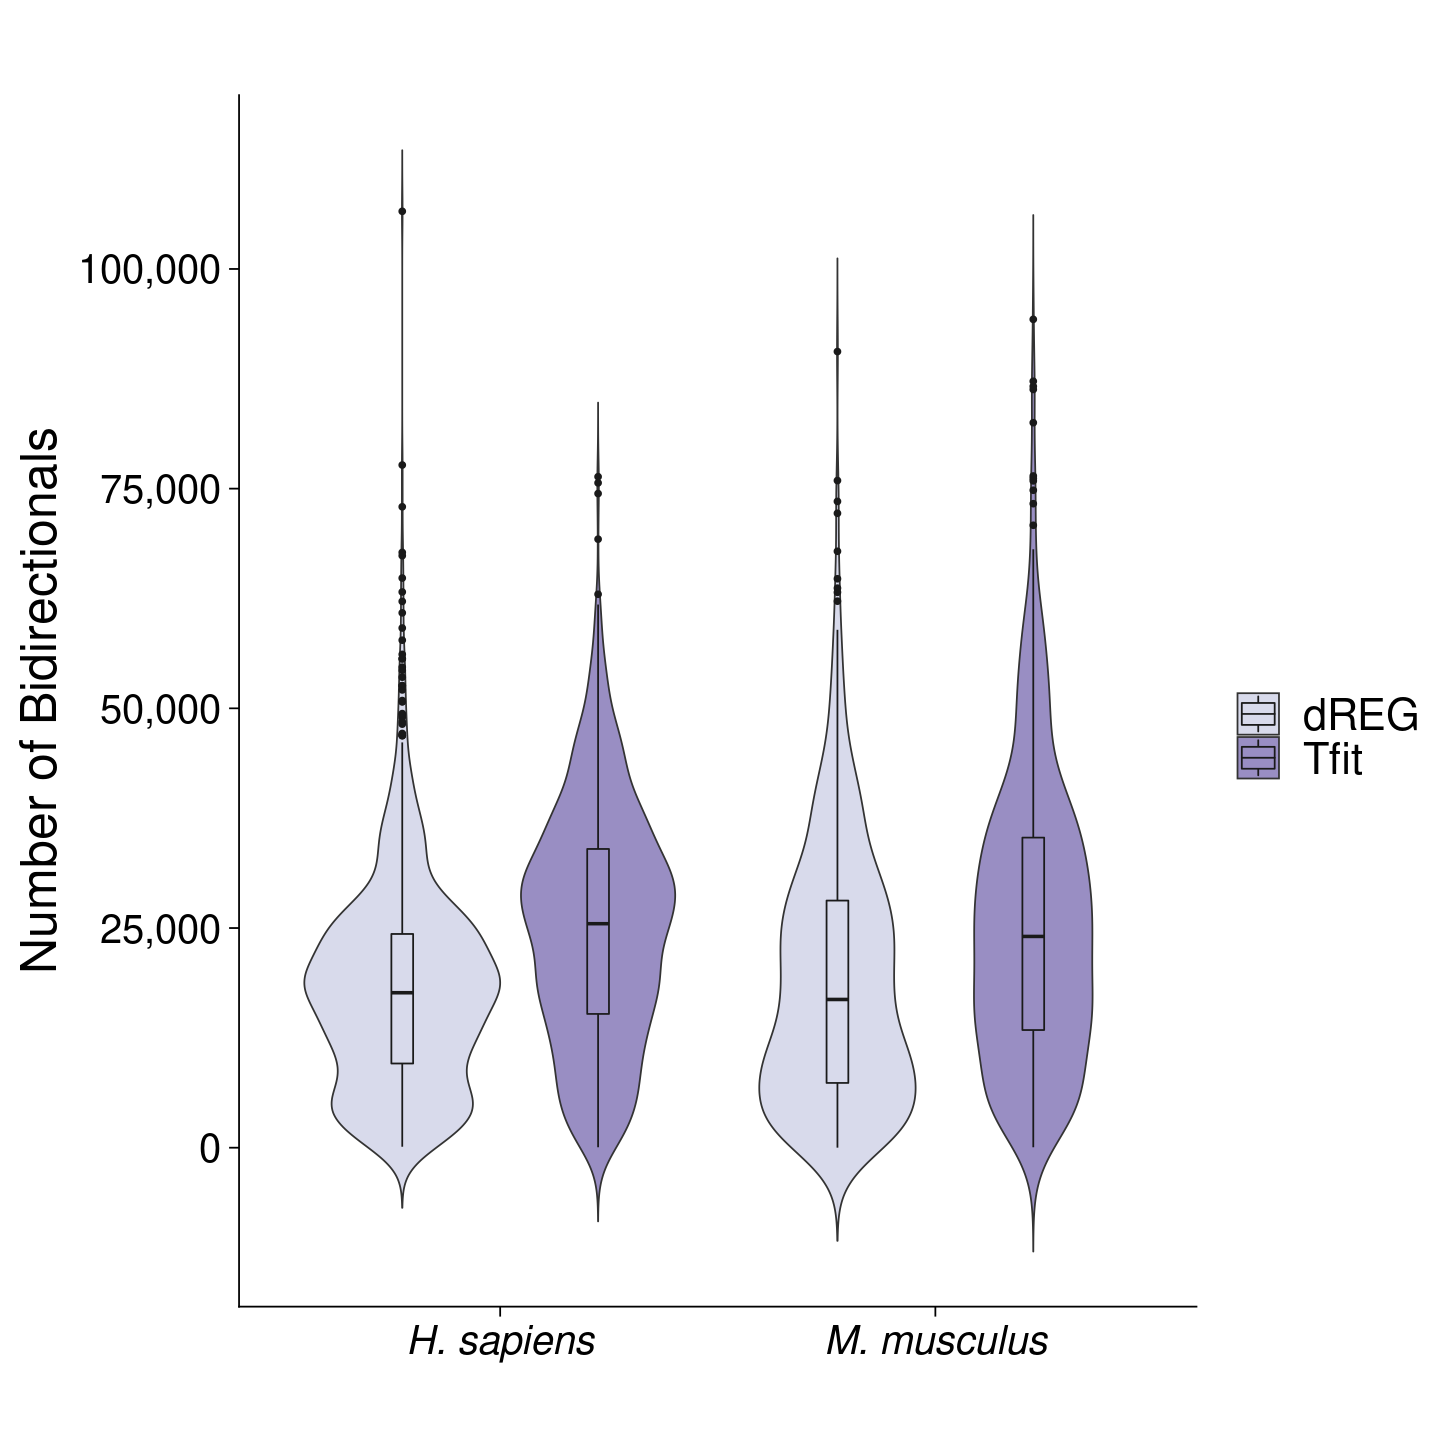

In [21]:
options(repr.plot.width=12, repr.plot.height=12)
bidir_calls <- ggplot(bidir_summary,
                     aes(x=organism, 
                          y=as.numeric(num_tfit_bidir),
                         fill=bidir_caller)) + 
geom_violin(trim=FALSE,position = position_dodge(0.9)) +
geom_boxplot(width=0.1, color='grey10',position = position_dodge(0.9)) + 
ggtitle(" ") +
ylab('Number of Bidirectionals') + 
xlab(' ') + 
scale_fill_manual(name=' ',
                  values = c("#d8daeb","#998ec3"))+ #c('#d01c8b','#4dac26')) + 
theme_cowplot(24) +
scale_y_continuous(#expand = c(0, 0), 
                   labels = scales::comma) +
#theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face = "bold"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24,face="italic"),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 28),
     legend.text = element_text(size = 26)) 

bidir_calls

In [22]:
ggsave(bidir_calls, width = 12, height = 12,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit.pdf", 
       bg = "transparent")

ggsave(bidir_calls, width = 12, height = 12,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit.png", 
       bg = "transparent")

In [23]:
bidir_summary_human <- subset(bidir_summary, organism=='H. sapiens')
bidir_summary_human

sample_name num_tfit_bidir num_tfit_bidir_promoter num_tfit_bidir_intronic
1    ERR769522    9110           4417                    1969                  
2    ERR769523    9020           4395                    2172                  
3    ERR769524   26783          11047                    7190                  
4    ERR769525   25374          11686                    6298                  
5    SRM497904   31725           9236                   10402                  
6    SRM497907   41733           9349                   15572                  
7    SRM497911   38799          10492                   13303                  
8    SRM497912   38875          10303                   13638                  
9    SRM497914   41935          10661                   14541                  
10   SRM497917   38565           8524                   14567                  
11   SRR10063517 29370          13542                    6875                  
12   SRR10063518 23836          12054                    5072                  
13   SRR10063519 28277          12224                    6772                  
14   SRR10063520 16920           8765                    3759                  
15   SRR10063521 21763          10778                    5055                  
16   SRR10063522 24022          11921                    5398                  
17   SRR10063523 20936           9089                    5216                  
18   SRR10063524 24420          11919                    5591                  
19   SRR10063525 31398          13771                    7323                  
20   SRR10063526 27612          11184                    7108                  
21   SRR10063527 17990           8777                    4026                  
22   SRR10063528 29163          12828                    6903                  
23   SRR10063529 26326           9599                    7230                  
24   SRR10063530 29945          14347                    6649                  
25   SRR10063531 22581          11058                    5166                  
26   SRR10063532 24194          11761                    5612                  
27   SRR10063533 17081           8633                    3546                  
28   SRR10063534 29977          11268                    8179                  
29   SRR10063535 26643           9379                    7566                  
30   SRR10063536 24280          11315                    5433                  
⋮    ⋮           ⋮              ⋮                       ⋮                      
2837 SRZ8795439  17828          14730                    2179                  
2838 SRZ8795447  17819          14775                    2055                  
2839 SRZ8795455  16933          14243                    2002                  
2840 SRZ8795463  17205          14449                    1956                  
2841 SRZ8795471  18211          14633                    2221                  
2842 SRZ8795479  16390          14126                    1792                  
2843 SRZ8795487  17350          14470                    1929                  
2844 SRZ8795495  17468          14516                    1913                  
2845 SRZ929970   12844           7352                    3238                  
2846 SRZ929974   10947           6794                    2369                  
2847 SRZ929981    7955           2320                    3357                  
2848 SRZ942404   21450           4646                    3512                  
2849 SRZ942407   22887           5679                    3977                  
2850 SRZ942410   20798           7995                    4427                  
2851 SRZ942413   14329           6849                    3242                  
2852 SRZ942415   21668          11609                    3453                  
2853 SRZ942418   24211          11840                    4749                  
2854 SRZ942421   15885           9099                    2677                  
2855 

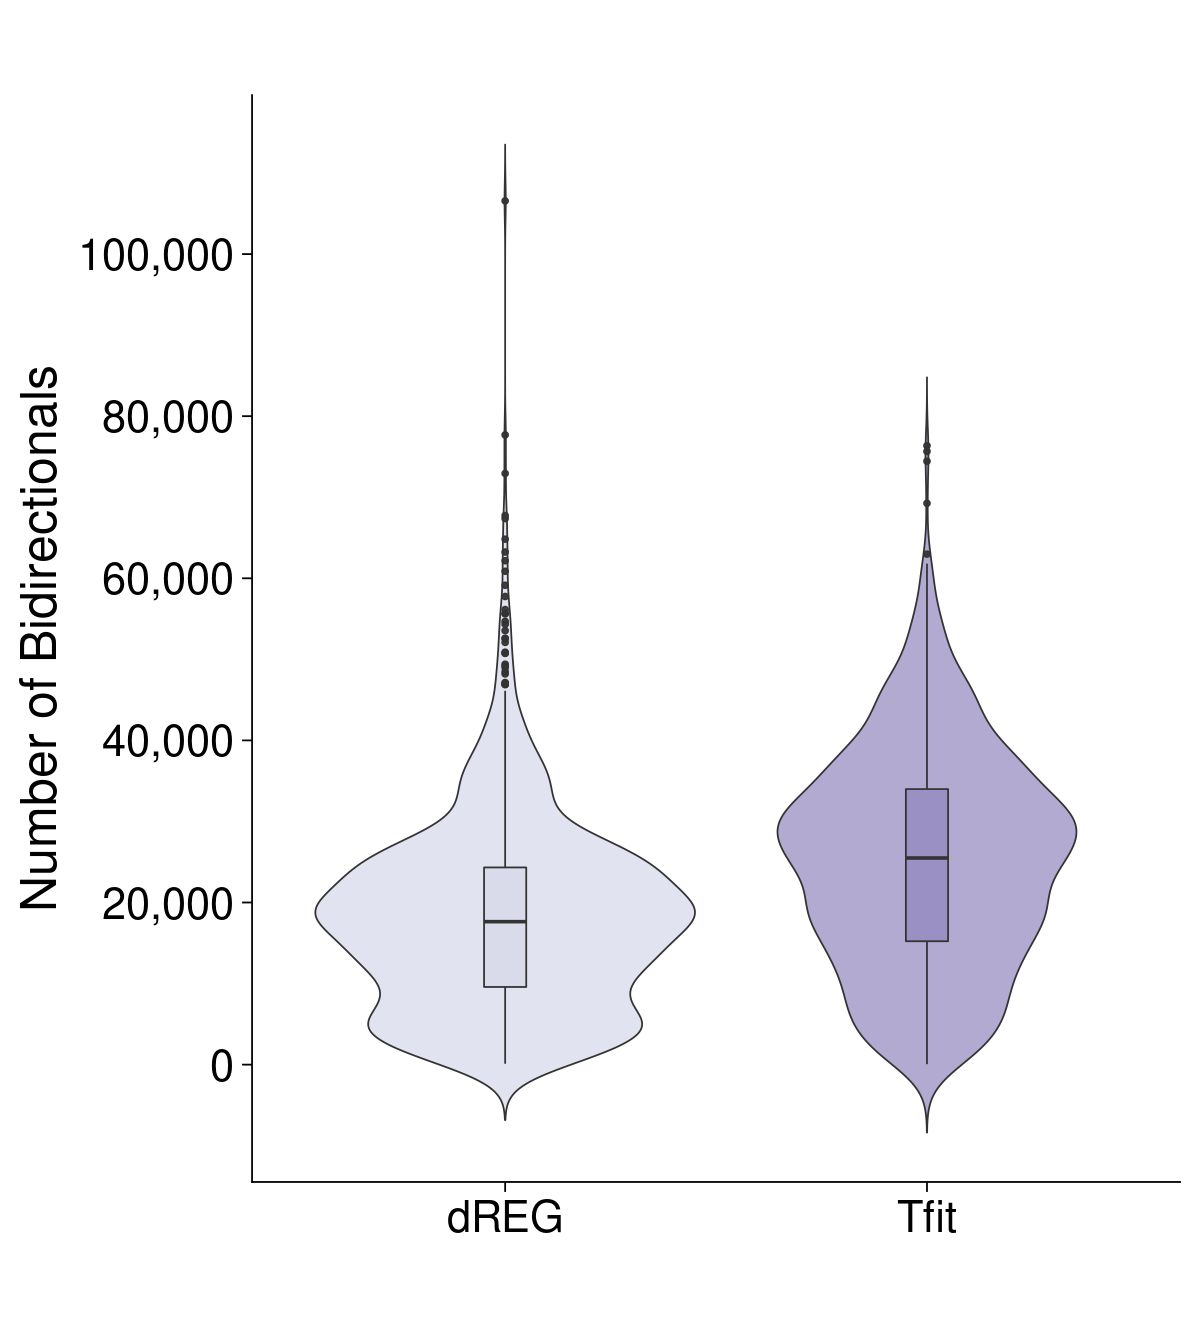

In [24]:
options(repr.plot.width=10, repr.plot.height=11)
bidir_calls2 <- ggplot(bidir_summary_human,
                     aes(x=bidir_caller, 
                          y=as.numeric(num_tfit_bidir),
                         fill=bidir_caller)) + 
geom_violin(trim=FALSE,position = position_dodge(0.9), alpha=0.75) +
geom_boxplot(width=0.1, color='grey20', alpha=0.95, position = position_dodge(0.9)) + 
ggtitle(" ") +
ylab('Number of Bidirectionals') + 
xlab(' ') + 
scale_fill_manual(name=' ',values = c("#d8daeb","#998ec3"))+ #c('#d01c8b','#4dac26')) +
theme_cowplot(24) +
scale_y_continuous(#expand = c(0, 0), 
                    breaks= c(0, 20000,40000,
                              60000,80000,
                              100000, 120000),
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face = "bold"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 26),
      axis.text.y = element_text(size = 26),
     legend.title = element_text(size = 30),
     legend.text = element_text(size = 28),
     legend.position = "none") 

bidir_calls2

In [25]:
ggsave(bidir_calls2, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit_human.pdf", 
       bg = "transparent")

ggsave(bidir_calls2, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit_human.png", 
       bg = "transparent")

In [26]:
bidir_summary_mouse <- subset(bidir_summary, organism=='M. musculus')
bidir_summary_mouse

sample_name num_tfit_bidir num_tfit_bidir_promoter num_tfit_bidir_intronic
1    SRR065240   12958           7277                    2066                  
2    SRR065241    9894           5737                    1742                  
3    SRR091798   26559          11935                    5376                  
4    SRR097862   13141           6598                    2005                  
5    SRR097863   10347           5401                    1866                  
6    SRR097864   10338           5351                    1880                  
7    SRR10067473 35618          11232                    9004                  
8    SRR10067474 38464          10871                    9556                  
9    SRR10067475 24395           8326                    6504                  
10   SRR10067476 19538           7660                    4598                  
11   SRR10067477 45641          14043                   10734                  
12   SRR10067478 23940           9093                    5204                  
13   SRR10067479 47316          13955                   11249                  
14   SRR10067480 44436          14202                    9918                  
15   SRR10439768  1680            836                     160                  
16   SRR10439769  1288            502                     129                  
17   SRR10439770  2018           1101                     248                  
18   SRR10439771  2528           1117                     336                  
19   SRR10439772  2272           1231                     271                  
20   SRR10439773  1032            465                     146                  
21   SRR10737798 51201          15583                   11595                  
22   SRR10737799 48903          16301                   10476                  
23   SRR10737800 51305          15541                   11698                  
24   SRR10737801 33908          16973                    6320                  
25   SRR10737802 33511          17214                    6022                  
26   SRR10737803 36909          18000                    7002                  
27   SRR10737804 58981          16185                   14730                  
28   SRR10737805 55868          15547                   14149                  
29   SRR10737806 59302          16164                   14966                  
30   SRR10737807 28019          10886                    7387                  
⋮    ⋮           ⋮              ⋮                       ⋮                      
1395 SRZ9007625  45038          12465                   11845                  
1396 SRZ9007627  18862           9397                    3461                  
1397 SRZ930649   18399          10000                    4036                  
1398 SRZ930653    6595           4921                     768                  
1399 SRZ930655   10137           6629                    1495                  
1400 SRZ930657    8912           6552                    1074                  
1401 SRZ930659   14825           8762                    3103                  
1402 SRZ930663    7048           5155                     927                  
1403 SRZ930665    8358           5709                    1214                  
1404 SRZ930667    9177           6437                    1195                  
1405 SRZ930677   19116          10166                    4161                  
1406 SRZ930682   16011           9289                    3310                  
1407 SRZ930691    6045           4786                     634                  
1408 SRZ930695    9888           7274                    1387                  
1409 SRZ930701    4035           3084                     501                  
1410 SRZ930707     820            132                     116                  
1411 SRZ930712    1495            514                     243                  
1412 SRZ935093   33305          11922                    7484                  
1413 

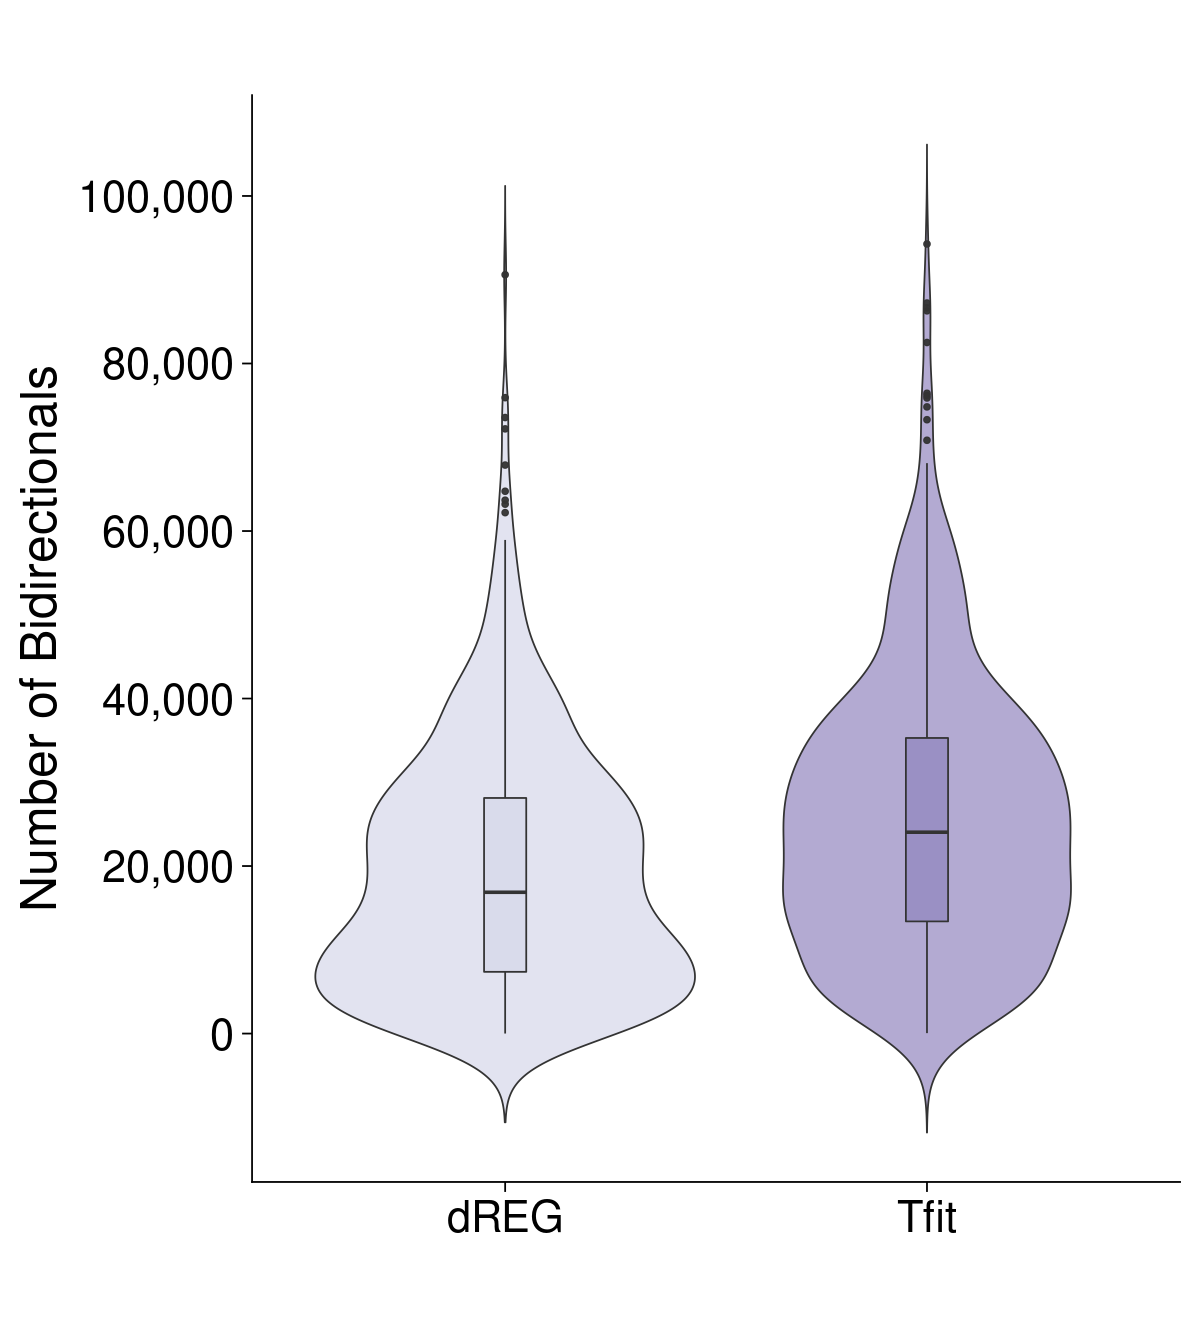

In [27]:
options(repr.plot.width=10, repr.plot.height=11)
bidir_calls_mouse <- ggplot(bidir_summary_mouse,
                     aes(x=bidir_caller, 
                          y=as.numeric(num_tfit_bidir),
                         fill=bidir_caller)) + 
geom_violin(trim=FALSE,position = position_dodge(0.9), alpha=0.75) +
geom_boxplot(width=0.1, color='grey20', alpha=0.95, position = position_dodge(0.9)) + 
ggtitle(" ") +
ylab('Number of Bidirectionals') + 
xlab(' ') + 
scale_fill_manual(name=' ',values = c("#d8daeb","#998ec3")) + #c('#d01c8b','#4dac26')) +
theme_cowplot(24) +
scale_y_continuous(#expand = c(0, 0), 
                    breaks= c(0, 20000,40000,
                              60000,80000,
                              100000, 120000),
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face = "bold"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 26),
      axis.text.y = element_text(size = 26),
     legend.title = element_text(size = 30),
     legend.text = element_text(size = 28),
     legend.position = "none") 

bidir_calls_mouse

In [28]:
ggsave(bidir_calls_mouse, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit_mouse.pdf", 
       bg = "transparent")

ggsave(bidir_calls_mouse, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/bidir_calls_dreg_tfit_mouse.png", 
       bg = "transparent")

### Venn diagram

In [29]:
hg38_bidirs$bidir_id <- paste0(hg38_bidirs$V1,":",
                              hg38_bidirs$V2,"-",
                              hg38_bidirs$V3)
head(hg38_bidirs)

V1   V2    V3    V4        bidir_id        
1 chr1  3729  7400 dreg      chr1:3729-7400  
2 chr1 10151 11371 tfit,dreg chr1:10151-11371
3 chr1 12344 12712 dreg      chr1:12344-12712
4 chr1 13249 13757 dreg      chr1:13249-13757
5 chr1 15110 15408 dreg      chr1:15110-15408
6 chr1 16191 17625 tfit,dreg chr1:16191-17625

In [30]:
hg38_bidir_regions <- list(
  Tfit = subset(hg38_bidirs, V4=='tfit' | V4=='tfit,dreg')$bidir_id, 
  dREG = subset(hg38_bidirs, V4=='dreg' | V4=='tfit,dreg')$bidir_id 
  )

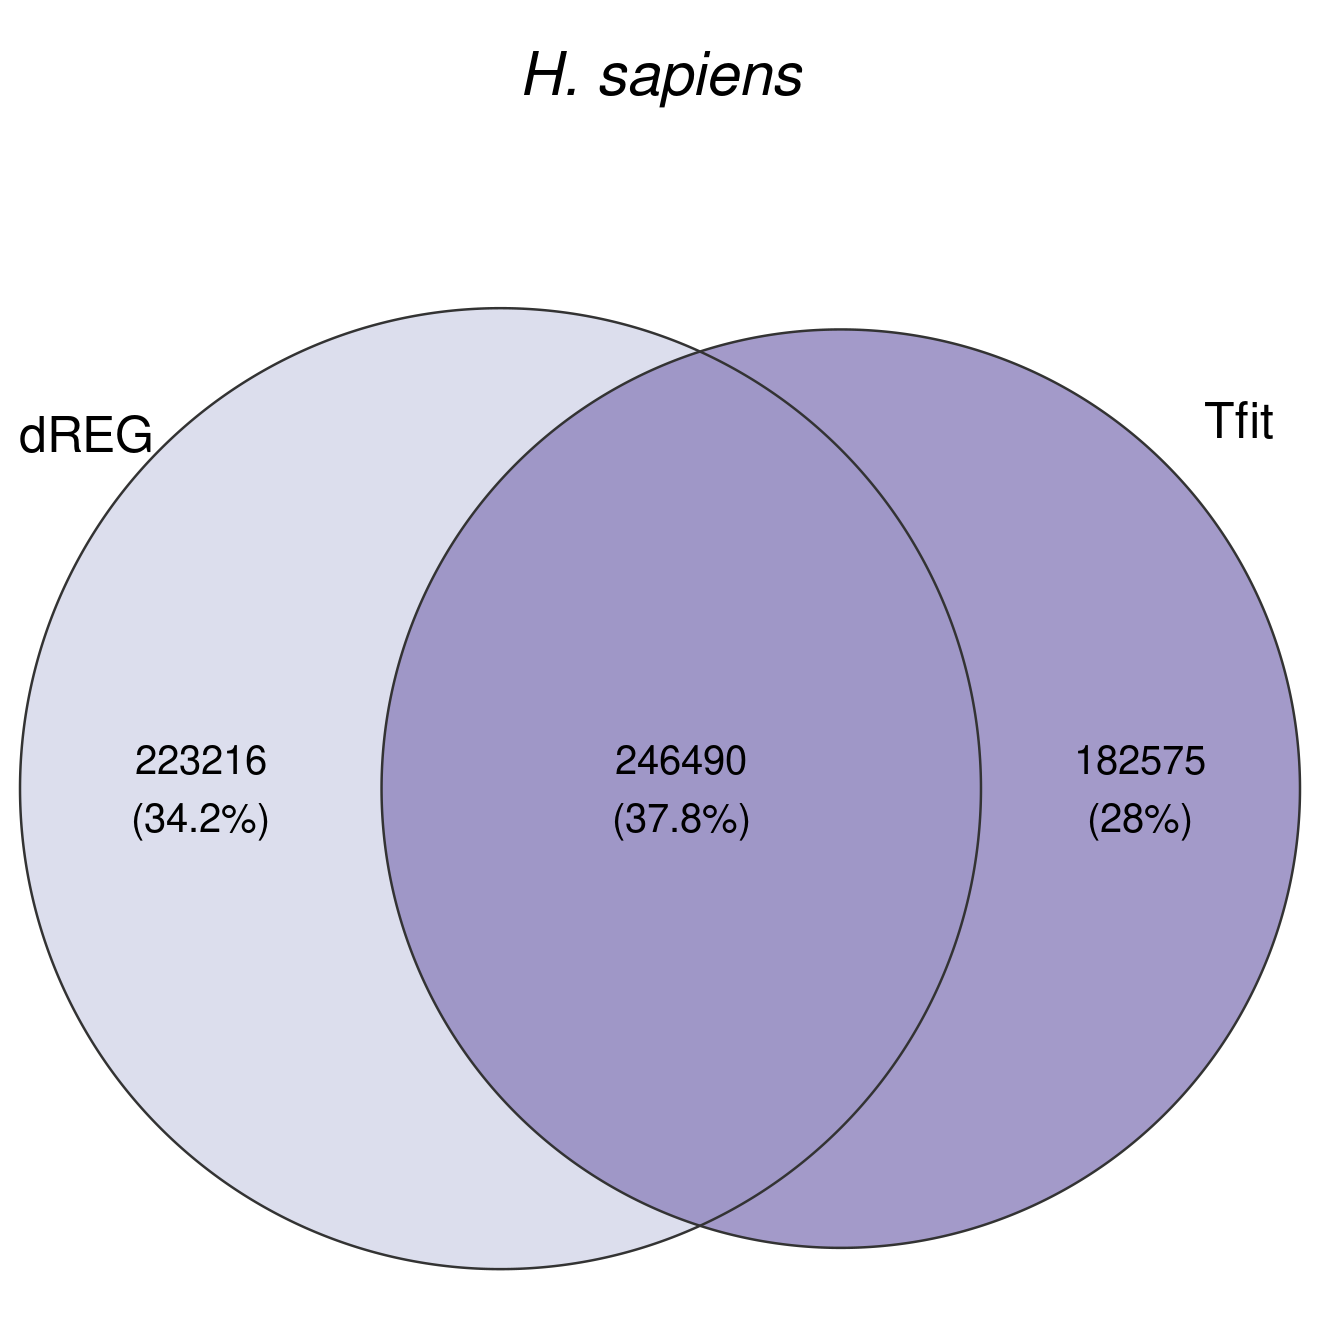

In [32]:
options(repr.plot.width=11, repr.plot.height=11)

hg38_venn0 <- venn.diagram(hg38_bidir_regions,
                           filename = NULL,
                           main="H. sapiens",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.90,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"),#'#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -19), c(0.5, -19)))

grid.draw(hg38_venn0);
grid.newpage()

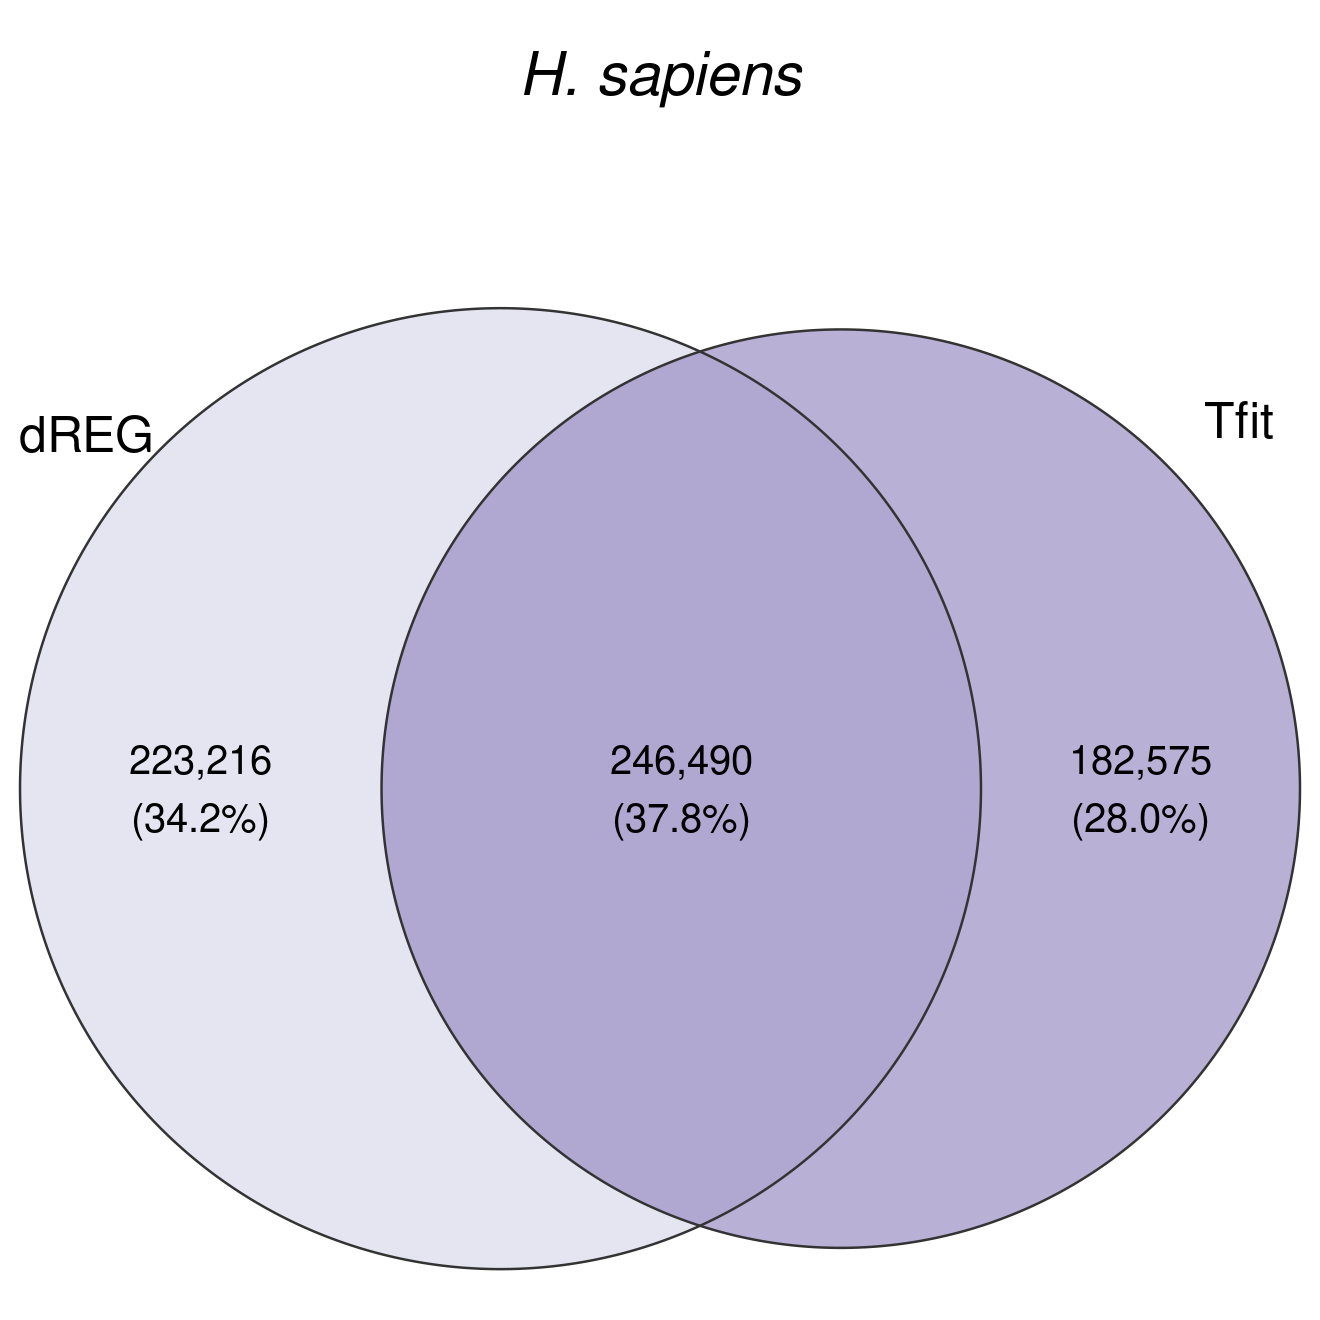

In [33]:
options(repr.plot.width=11, repr.plot.height=11)

hg38_venn <- venn.diagram(hg38_bidir_regions,
                           filename = NULL,
                           main="H. sapiens",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"), #c('#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -19), c(0.5, -19)))

hg38_venn[[5]][["label"]] <- "223,216\n(34.2%)"
hg38_venn[[6]][["label"]] <- "182,575\n(28.0%)"
hg38_venn[[7]][["label"]] <- "246,490\n(37.8%)"

grid.draw(hg38_venn);
grid.newpage()

In [34]:
ggsave(hg38_venn, 
       file="/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_bidir_venn.svg",
       device = "svg")
ggsave(hg38_venn, width = 6, height = 6,
       file="/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_bidir_venn.pdf",
       bg = "transparent")

Saving 6.67 x 6.67 in image



In [35]:
mm10_bidirs$bidir_id <- paste0(mm10_bidirs$V1,":",
                              mm10_bidirs$V2,"-",
                              mm10_bidirs$V3)
head(mm10_bidirs)

V1   V2   V3    V4   bidir_id       
1 chr1   35   417 dreg chr1:35-417    
2 chr1 1160  2910 dreg chr1:1160-2910 
3 chr1 3701  4600 dreg chr1:3701-4600 
4 chr1 6402  6700 dreg chr1:6402-6700 
5 chr1 8718  9112 dreg chr1:8718-9112 
6 chr1 9664 10882 dreg chr1:9664-10882

In [36]:
mm10_bidir_regions <- list(
  Tfit = subset(mm10_bidirs, V4=='tfit' | V4=='tfit,dreg')$bidir_id, 
  dREG = subset(mm10_bidirs, V4=='dreg' | V4=='tfit,dreg')$bidir_id 
  )

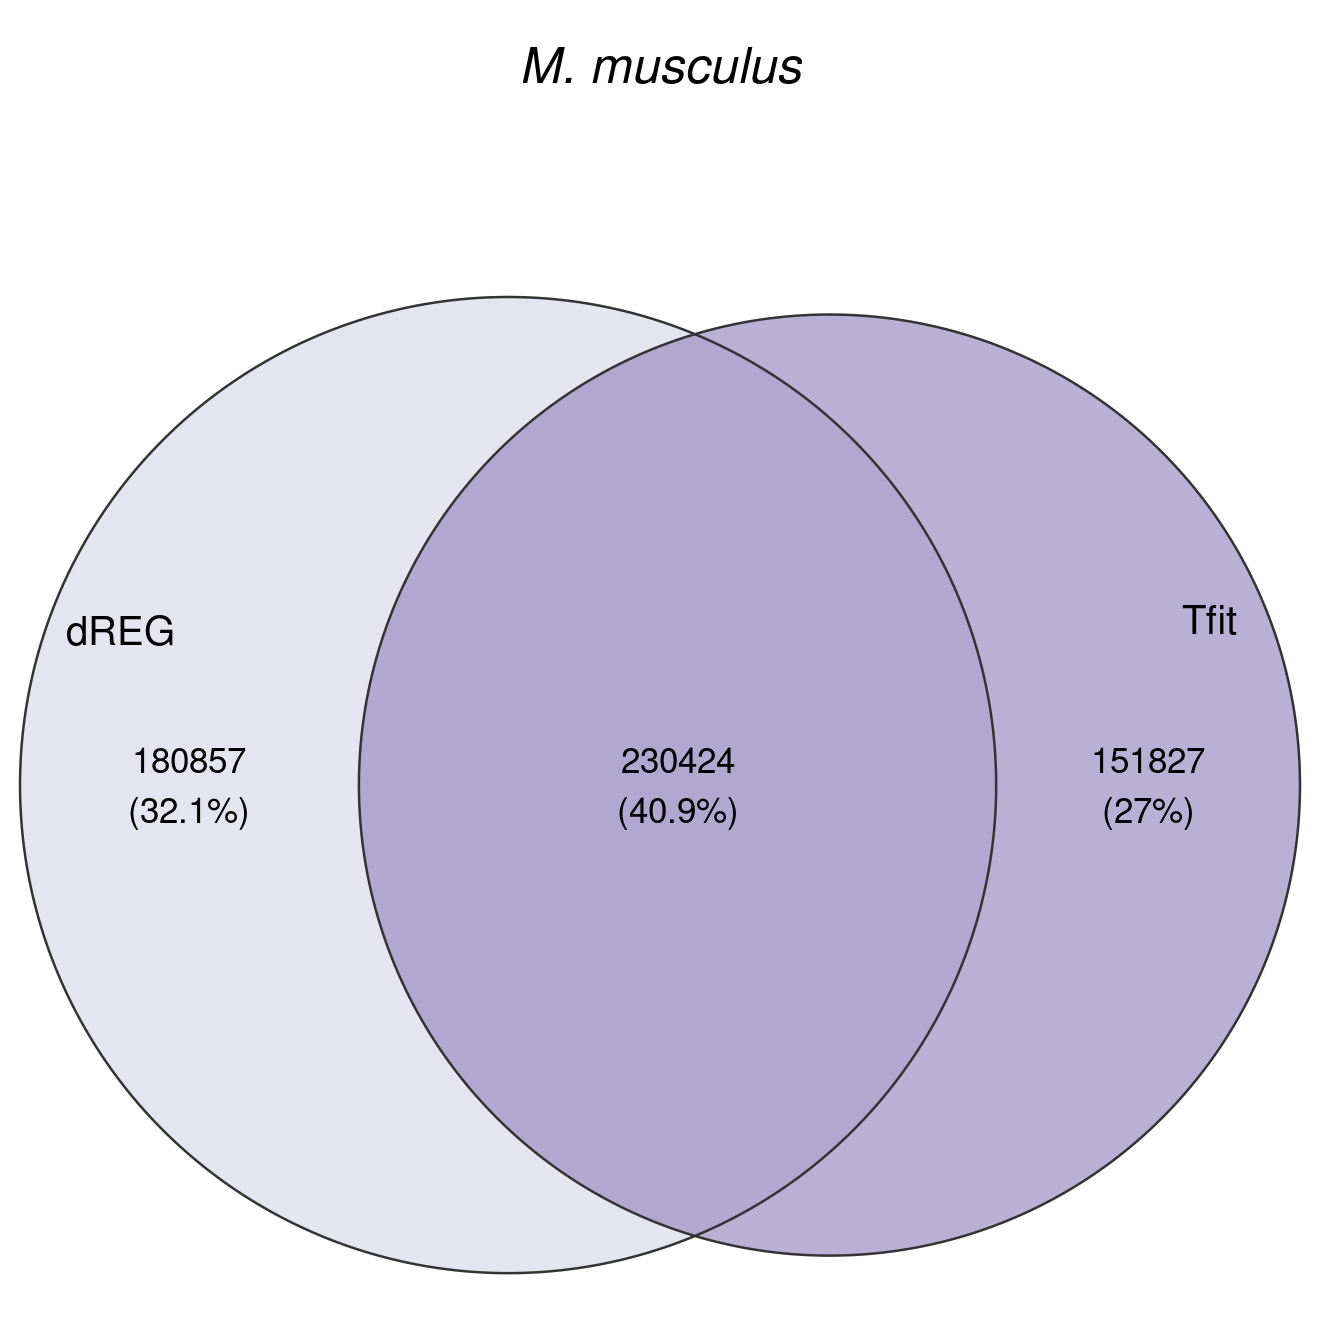

In [37]:
options(repr.plot.width=11, repr.plot.height=11)

mm10_venn0 <- venn.diagram(mm10_bidir_regions,
                           filename = NULL,
                           main="M. musculus",
                           main.cex = 2.5,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb") , #c('#4dac26','#d01c8b'),
                           cex = rep(1.75, 3),
                           cat.cex = rep(2, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(1, -17), c(0.2, -17)))


grid.draw(mm10_venn0);
grid.newpage()

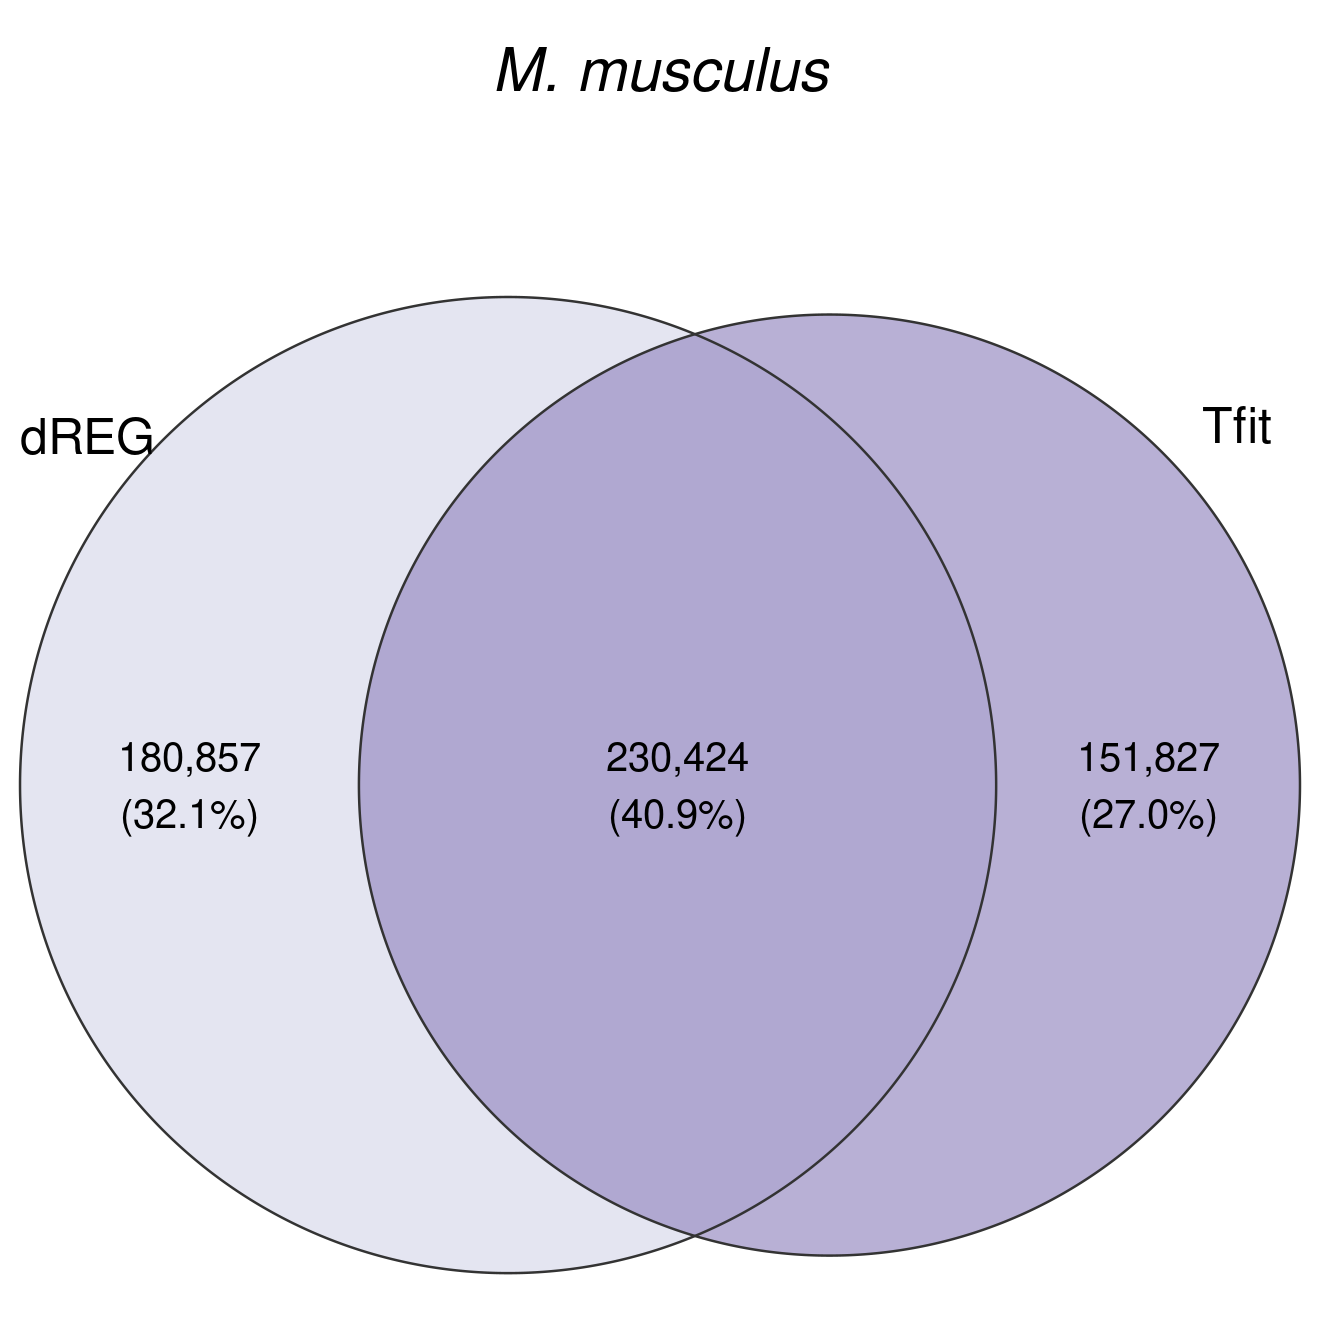

In [38]:
options(repr.plot.width=11, repr.plot.height=11)

mm10_venn <- venn.diagram(mm10_bidir_regions,
                           filename = NULL,
                           main="M. musculus",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"), #c('#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -19), c(0.5, -19)))

mm10_venn[[5]][["label"]] <- "180,857\n(32.1%)"
mm10_venn[[6]][["label"]] <- "151,827\n(27.0%)"
mm10_venn[[7]][["label"]] <- "230,424\n(40.9%)"

grid.draw(mm10_venn);
grid.newpage()

In [39]:
ggsave(mm10_venn, 
       file="/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_bidir_venn.svg", 
       device = "svg")

ggsave(mm10_venn, width = 6, height = 6,
       file="/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_bidir_venn.pdf",
       bg = "transparent")

Saving 6.67 x 6.67 in image



# Where do the bidirectional transcripts fall in genome

## Human

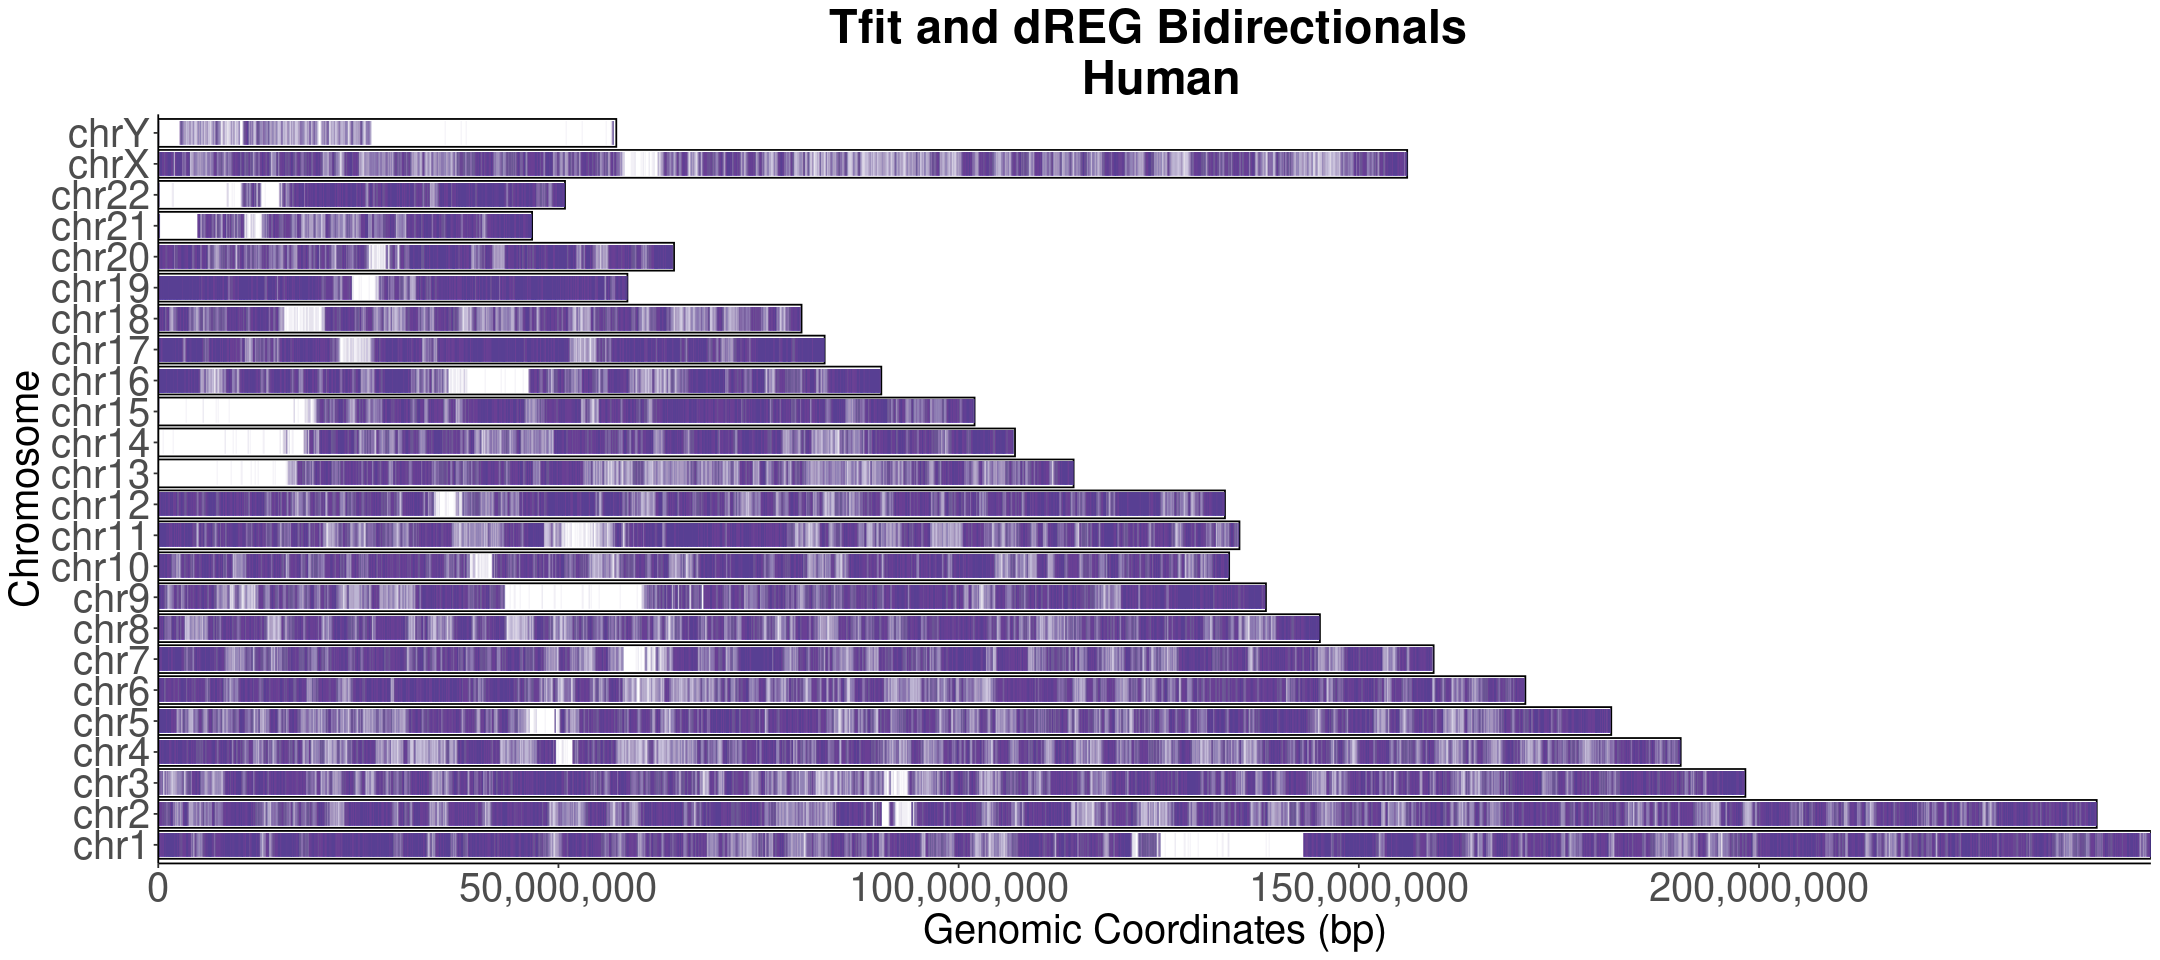

In [40]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_bidirs_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = hg38_bidirs,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#5e3c99',#'orange',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit and dREG Bidirectionals \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_bidirs_plot

In [41]:
ggsave(hg38_bidirs_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_bidirs_genome.png", 
       bg = "transparent")

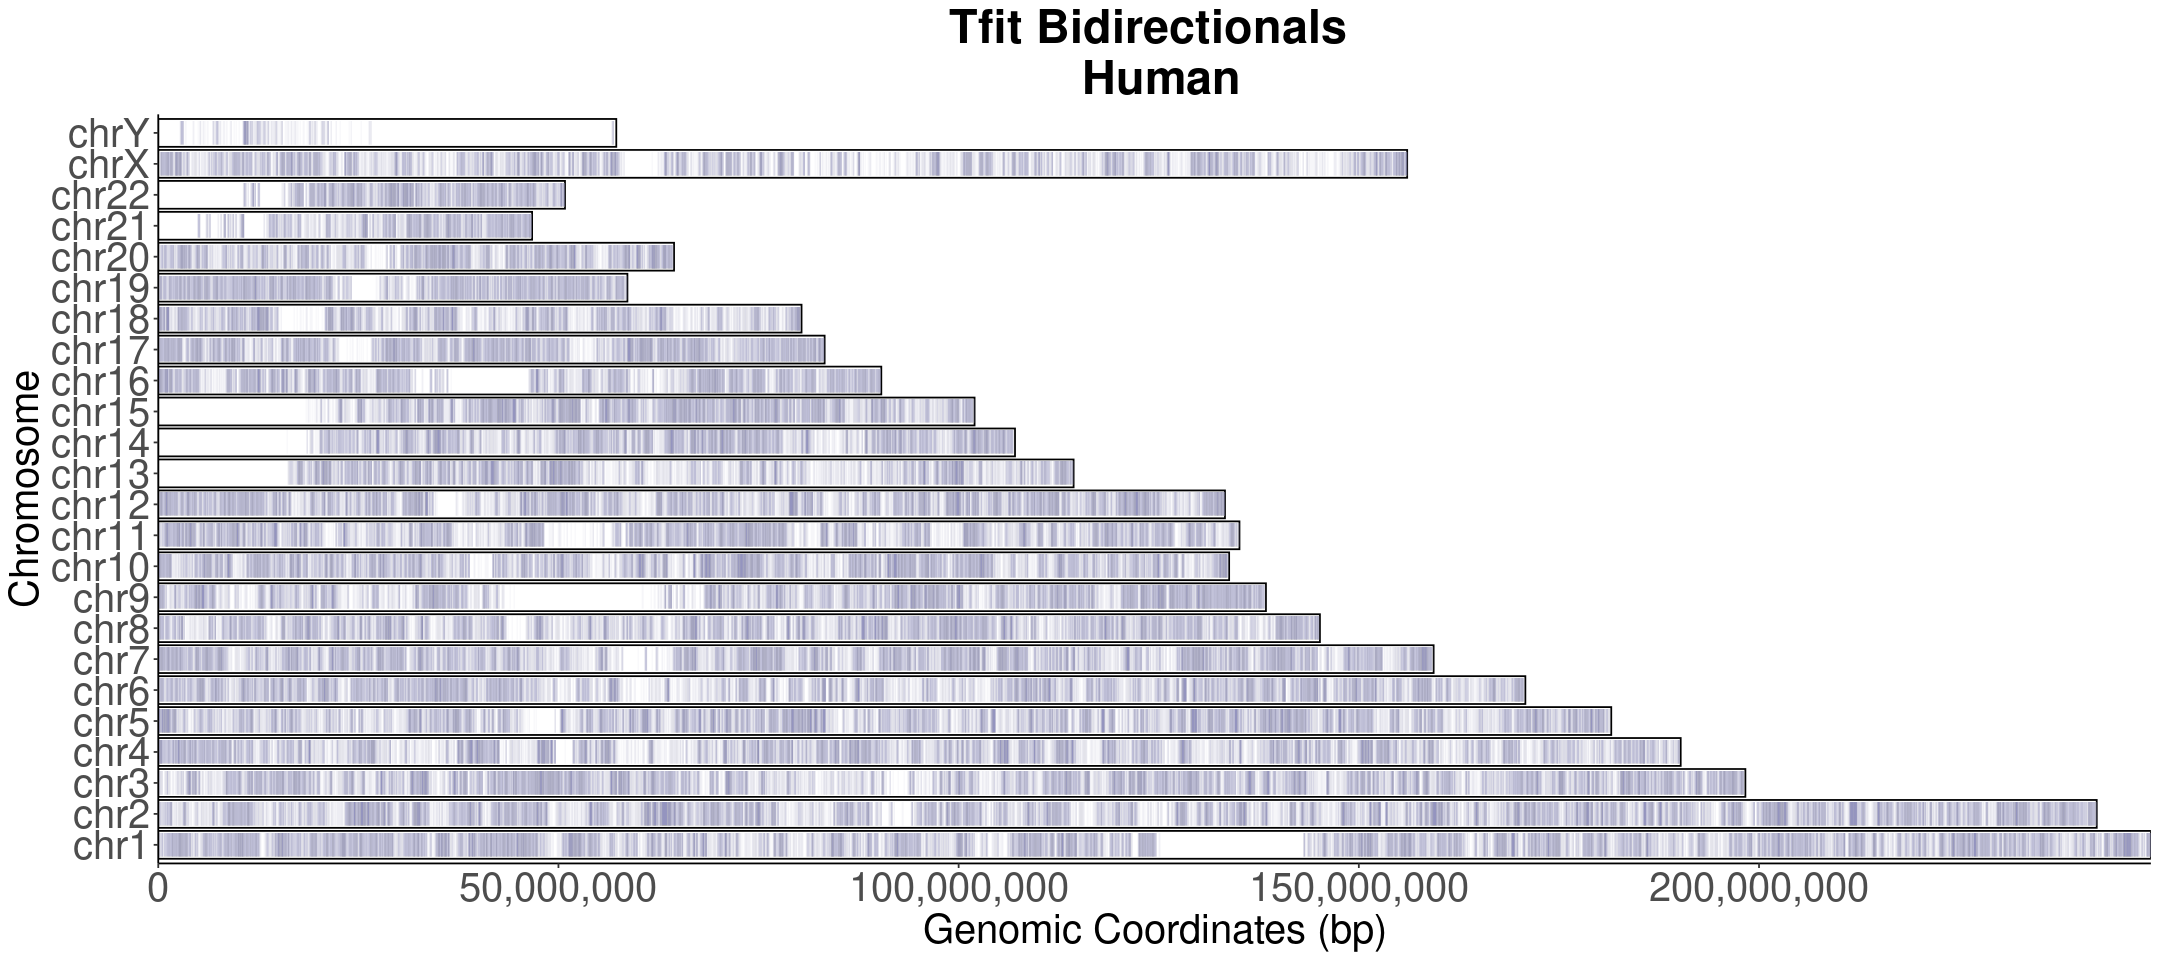

In [42]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_tfit_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = subset(hg38_bidirs, V4=="tfit"),
           aes(y = V1, x = V2), 
           shape=124, 
           color= '#998ec3', #'#4dac26',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit Bidirectionals \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_tfit_plot

In [43]:
ggsave(hg38_tfit_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_tfit_genome.png", 
       bg = "transparent")

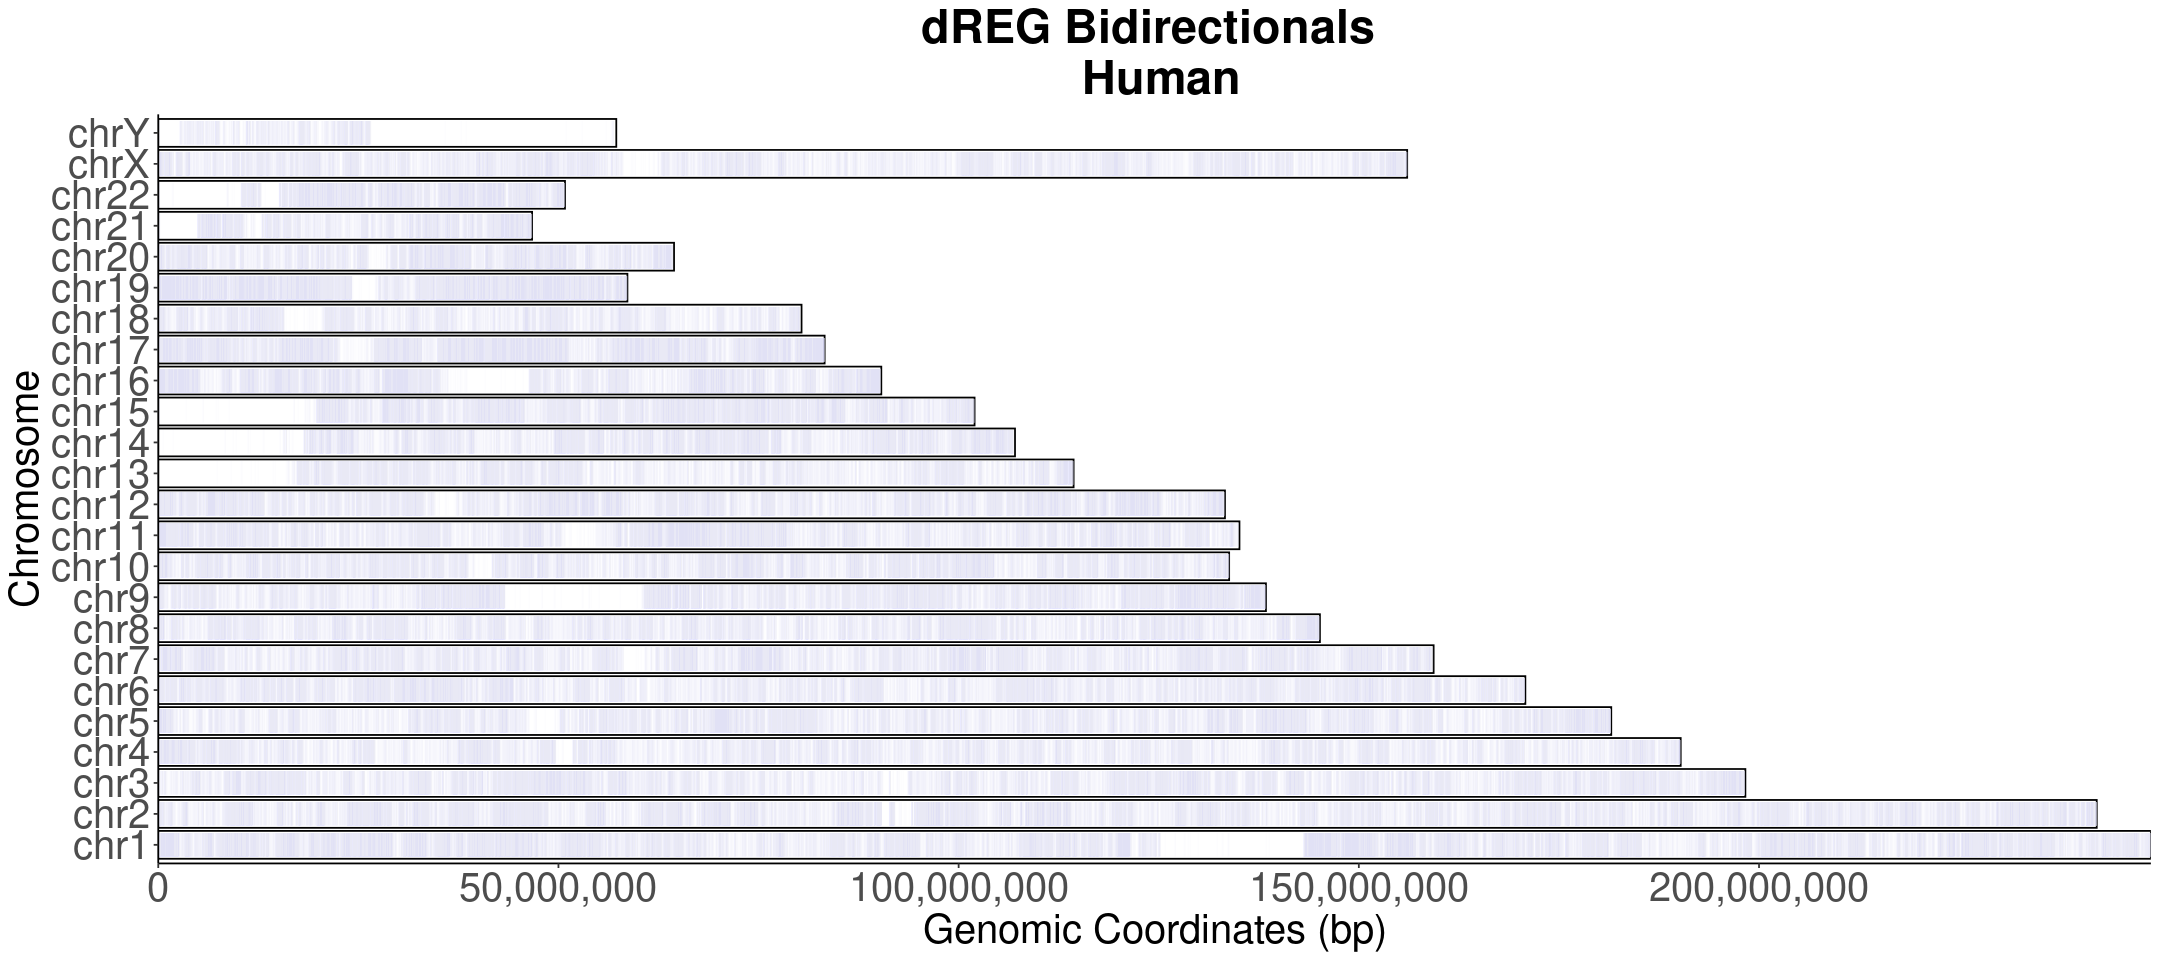

In [44]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_dreg_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = subset(hg38_bidirs, V4=="dreg"),
           aes(y = V1, x = V2), 
           shape=124, 
           color='#d8daeb',#'#d01c8b',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("dREG Bidirectionals \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_dreg_plot

In [45]:
ggsave(hg38_dreg_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_dreg_genome.png", 
       bg = "transparent")

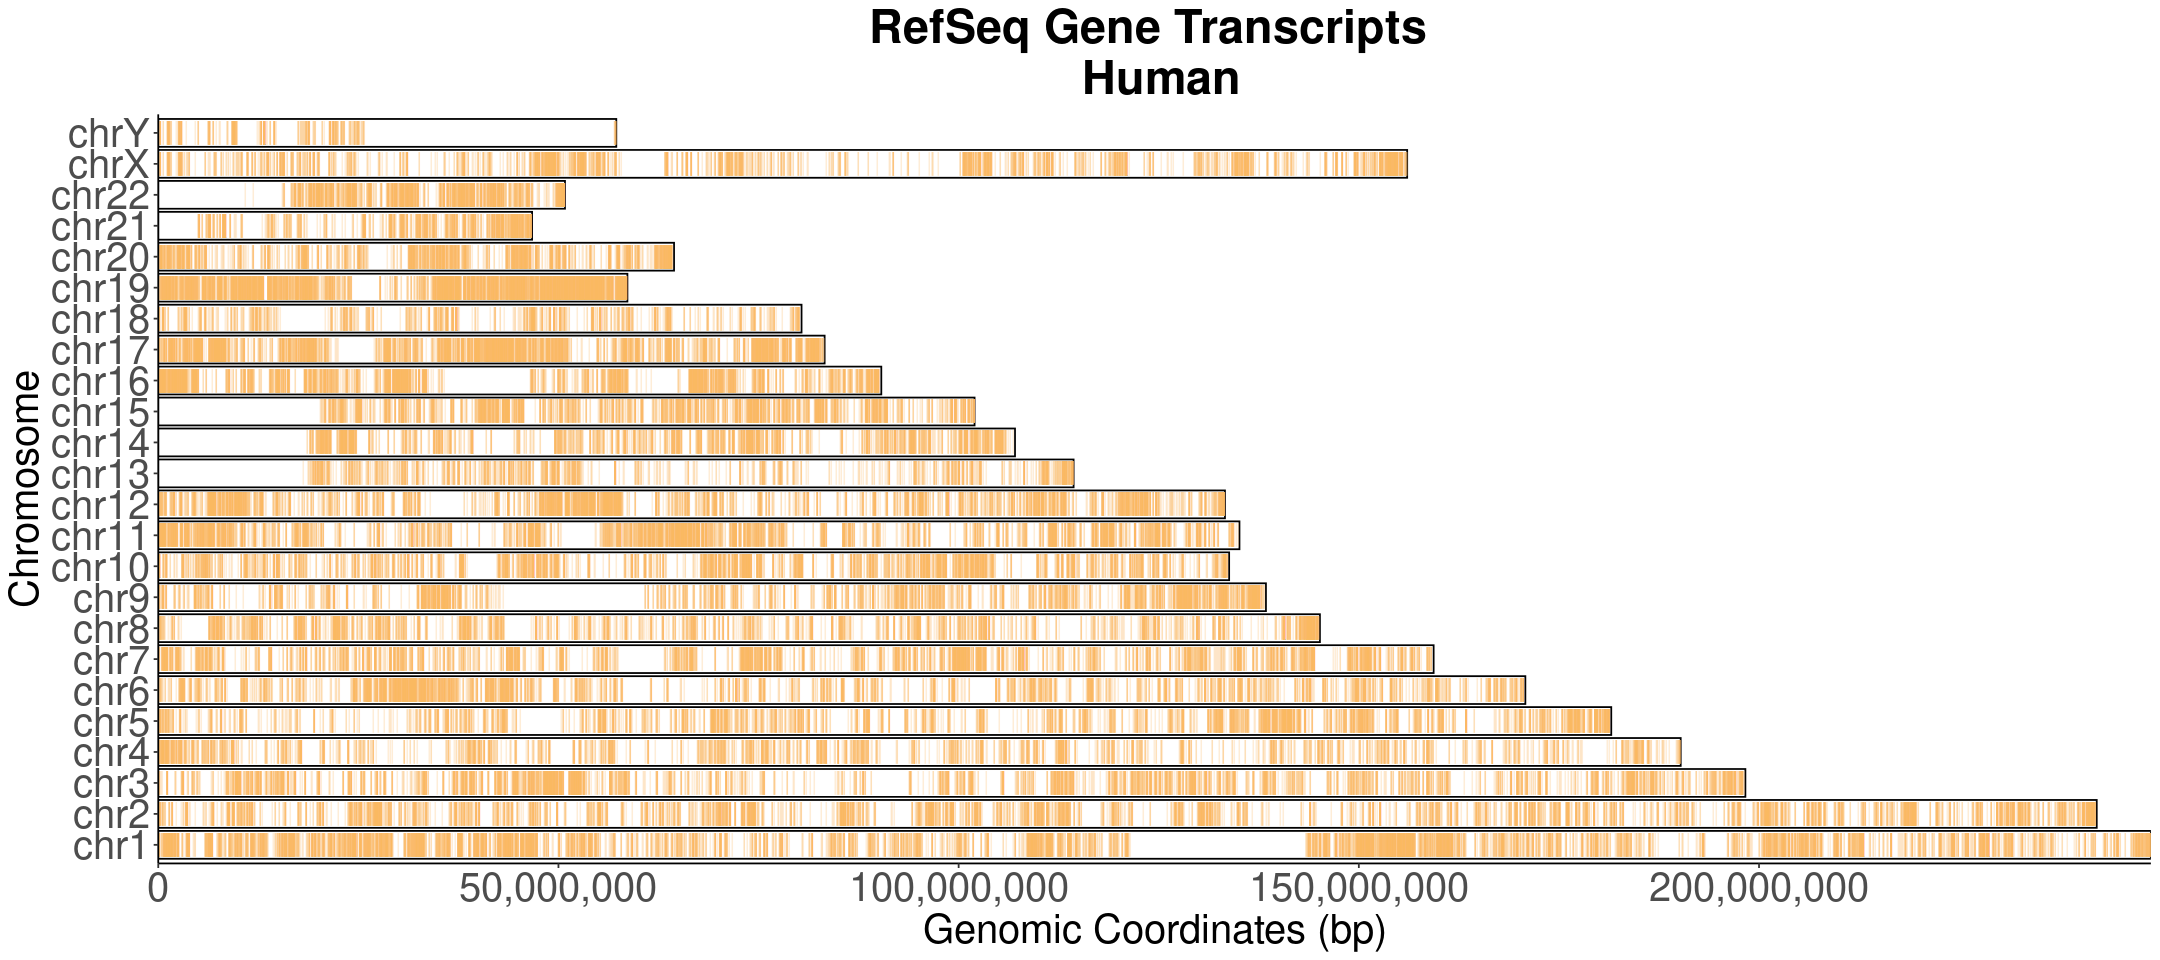

In [46]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_refseq_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = hg38_refseq_chr,
           aes(y = V1, x = V2), 
           shape=124, 
           color= '#fdb863',#'gray40',
           size=5, 
           alpha=0.25) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
#ggtitle("Tfit Bidirectionals \n hg38 RefSeq Gene Transcripts") +
ggtitle("RefSeq Gene Transcripts \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_refseq_plot

In [47]:
ggsave(hg38_refseq_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_refseq_genome.png", 
       bg = "transparent")

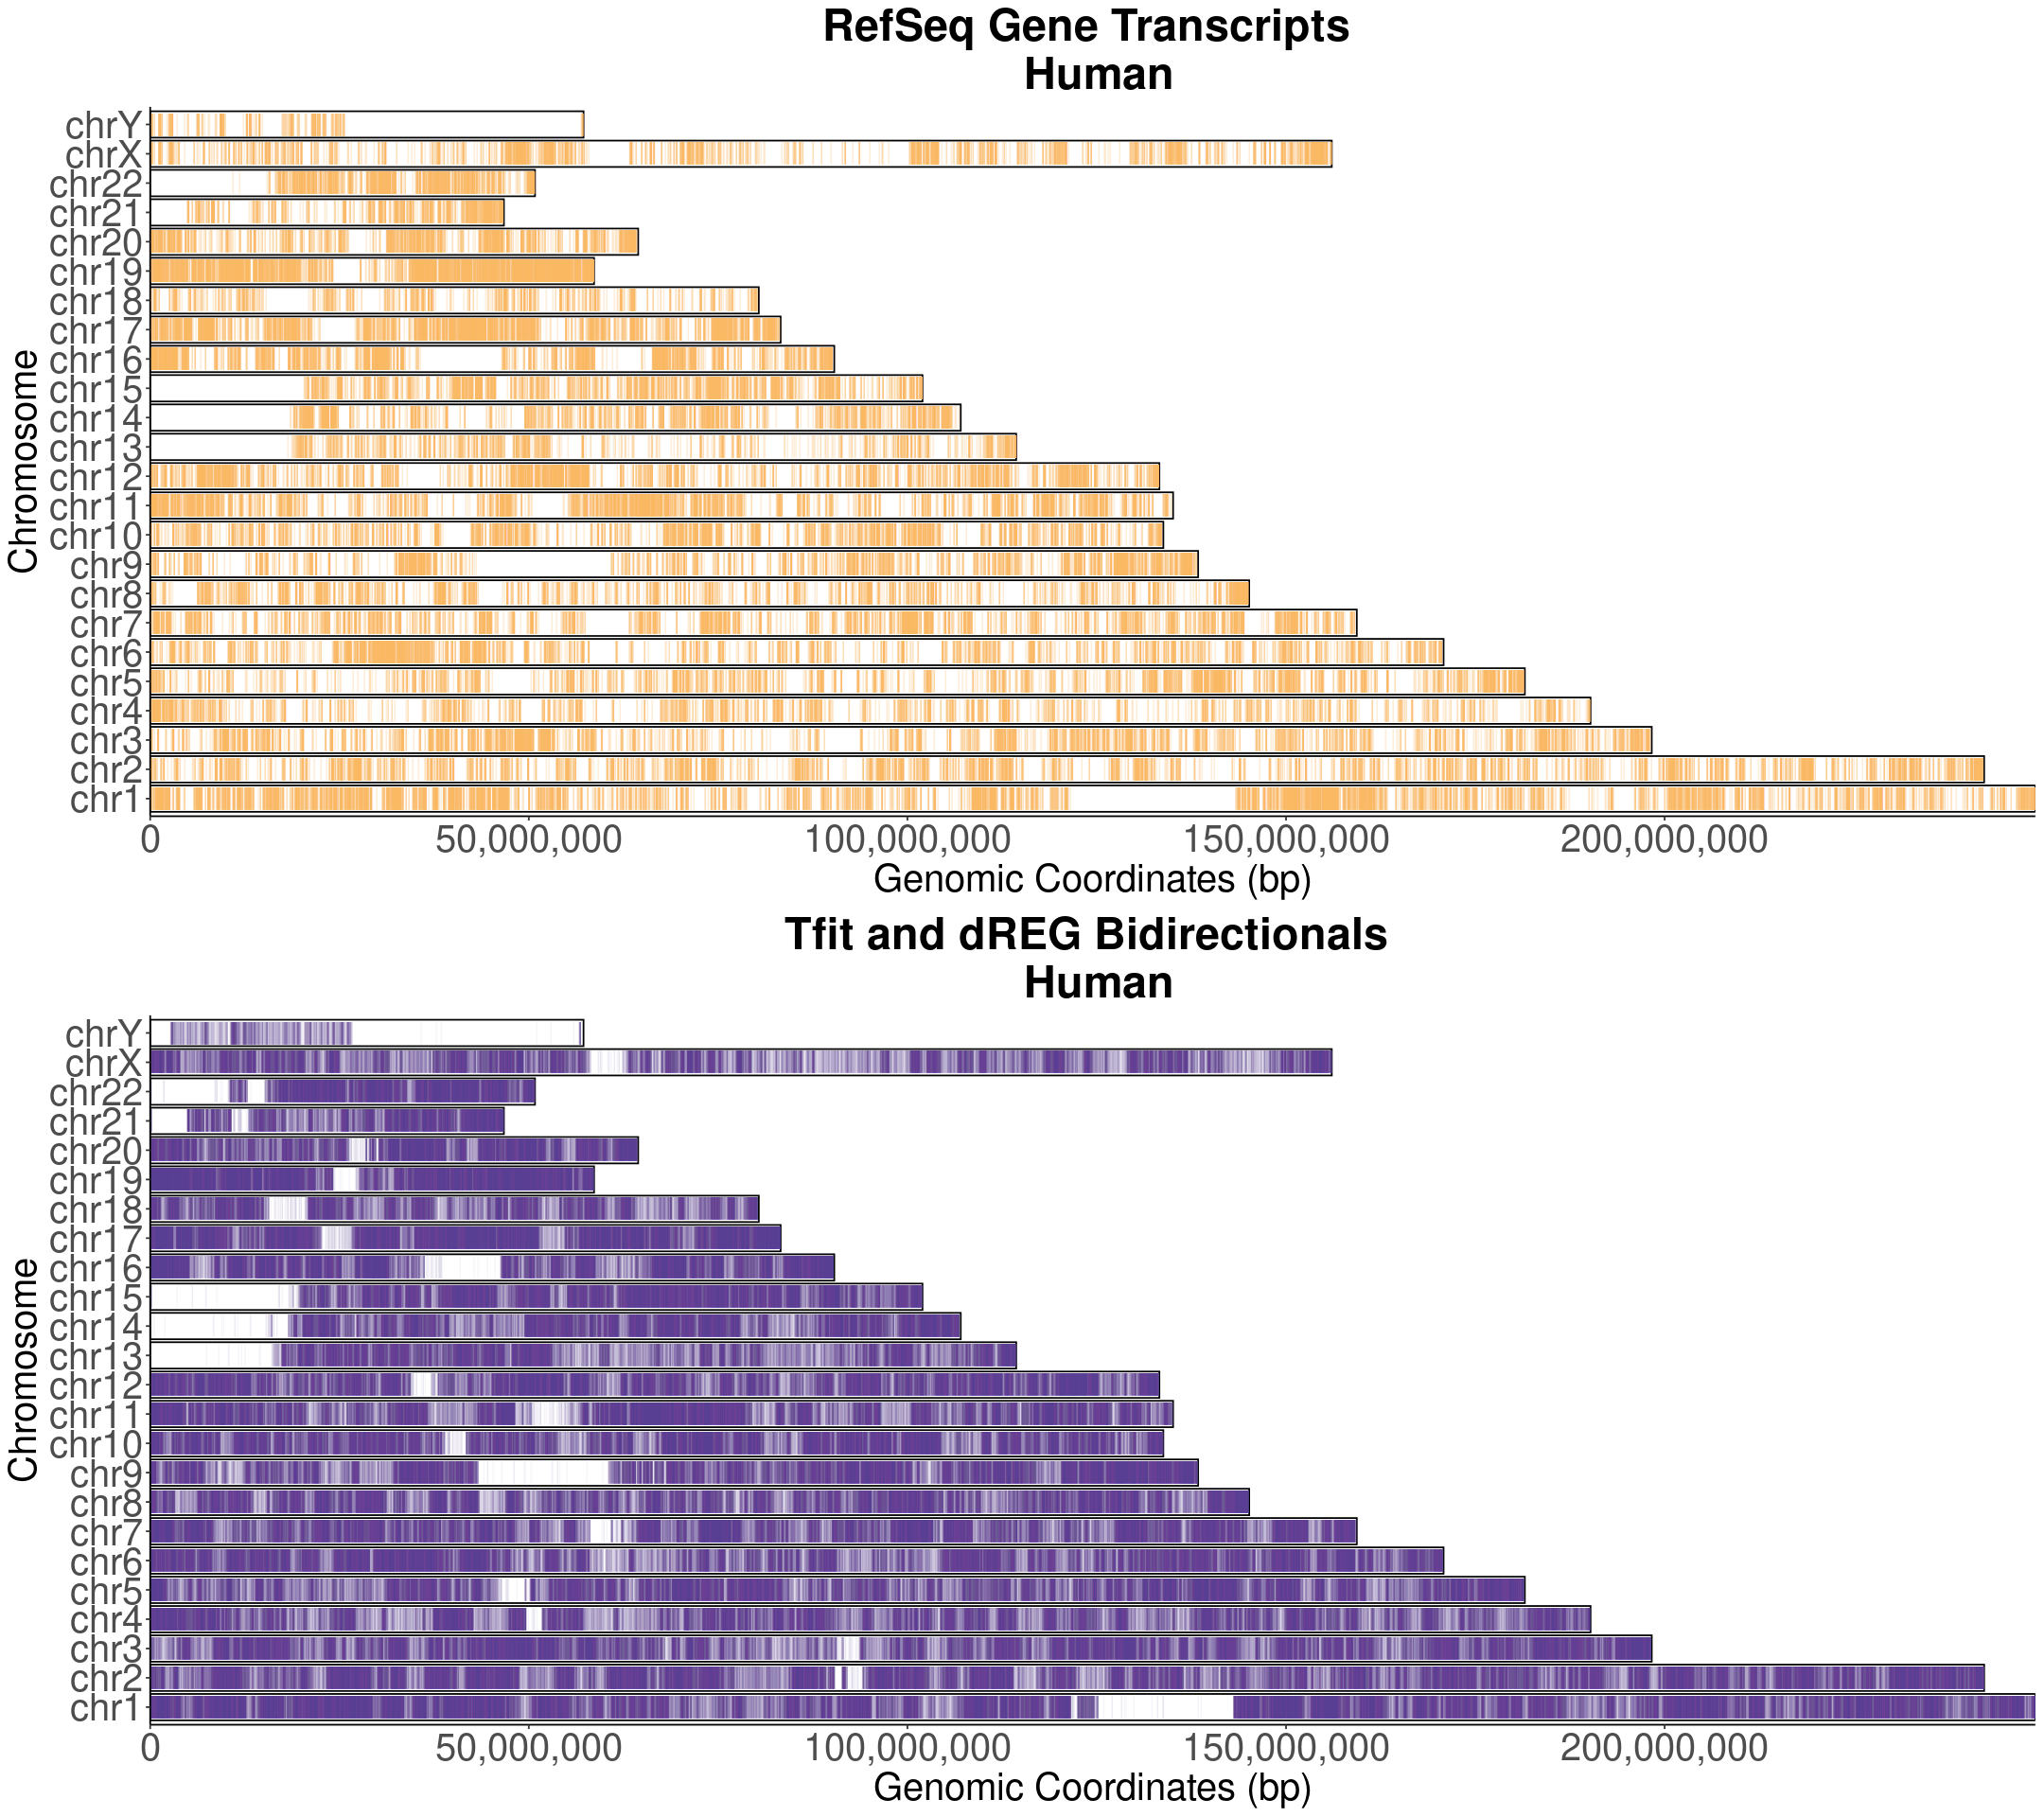

In [57]:
options(repr.plot.width=18, repr.plot.height=16)
hg38_refseq_bidirs_plot <- cowplot::plot_grid(hg38_refseq_plot,
                                              hg38_bidirs_plot,
                                              ncol = 1)
hg38_refseq_bidirs_plot

In [58]:
ggsave(hg38_refseq_bidirs_plot, width = 18, height = 16,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_refseq_bidirs_genome.png", 
       bg = "transparent")

## Mouse

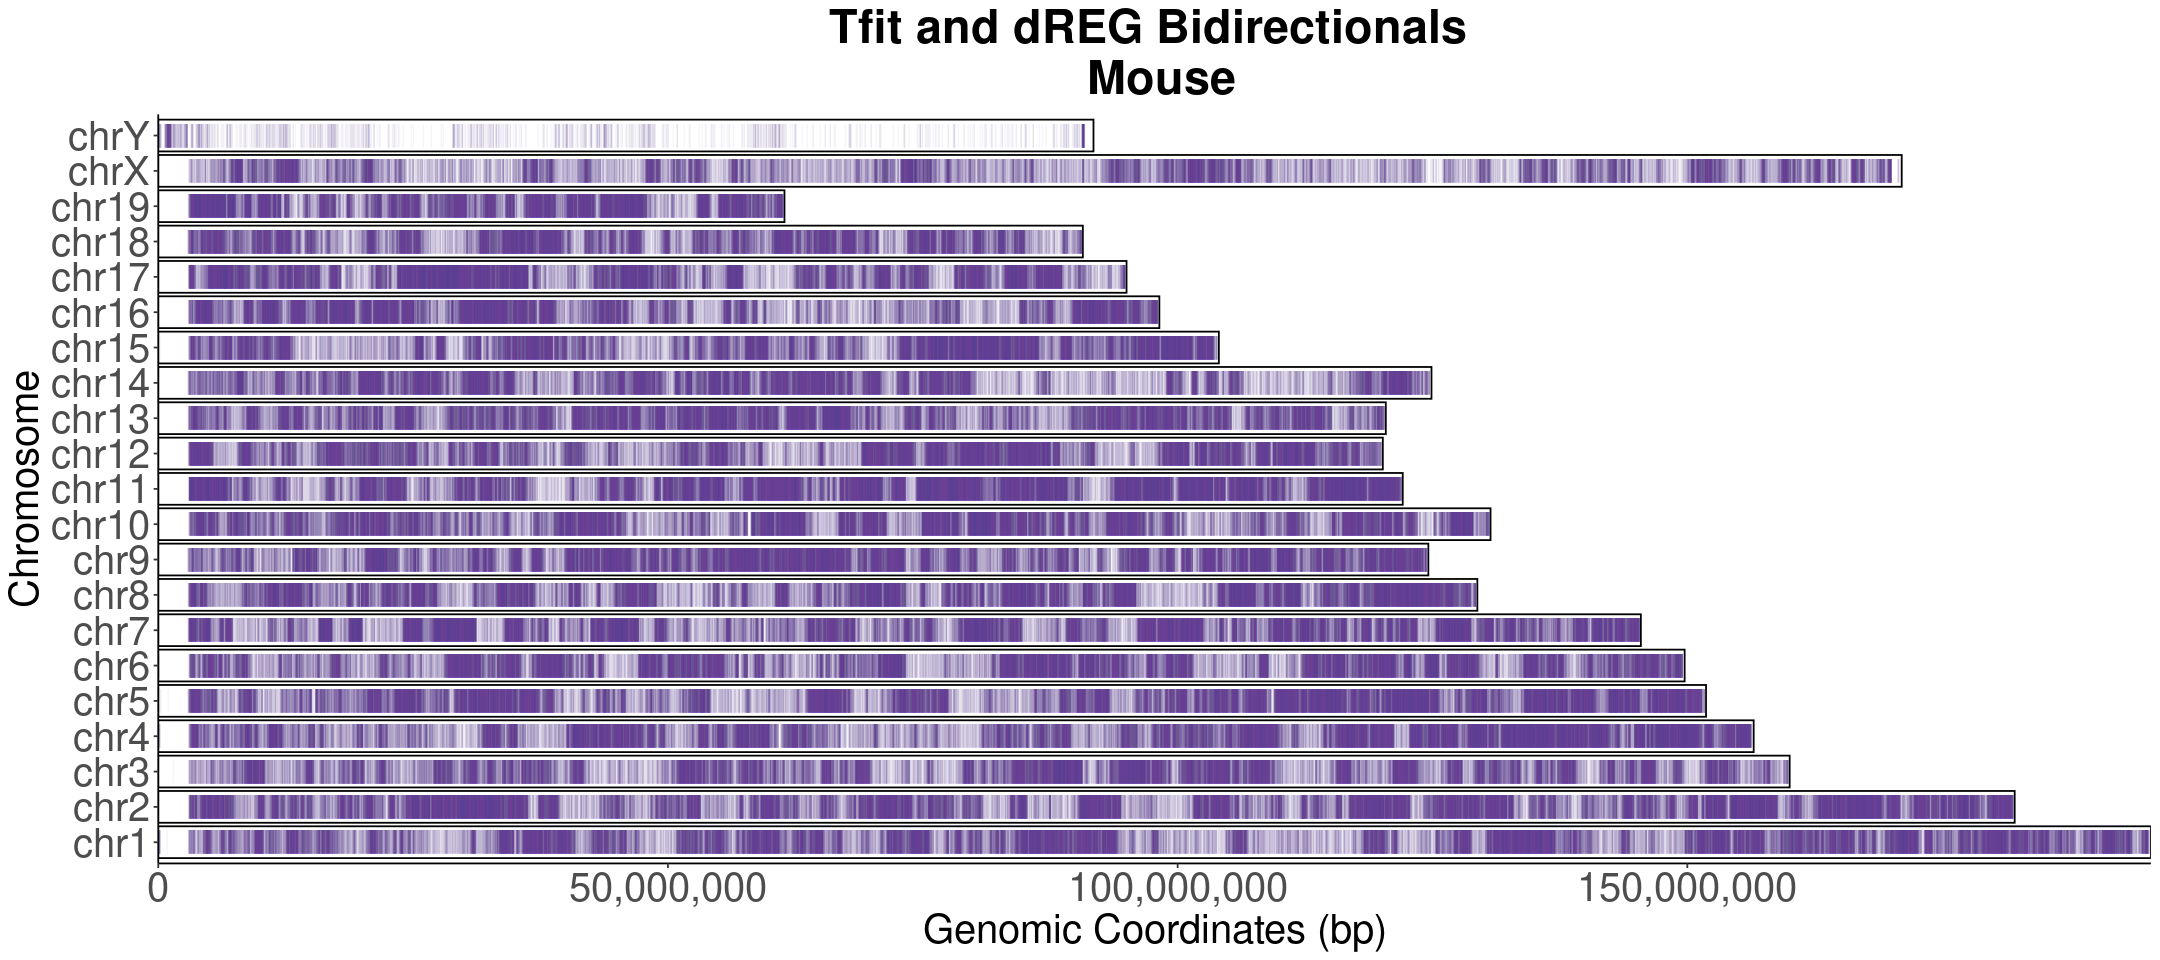

In [48]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_bidirs_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = mm10_bidirs,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#5e3c99',#'orange',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit and dREG Bidirectionals \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_bidirs_plot

In [49]:
ggsave(mm10_bidirs_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_bidirs_genome.png", 
       bg = "transparent")

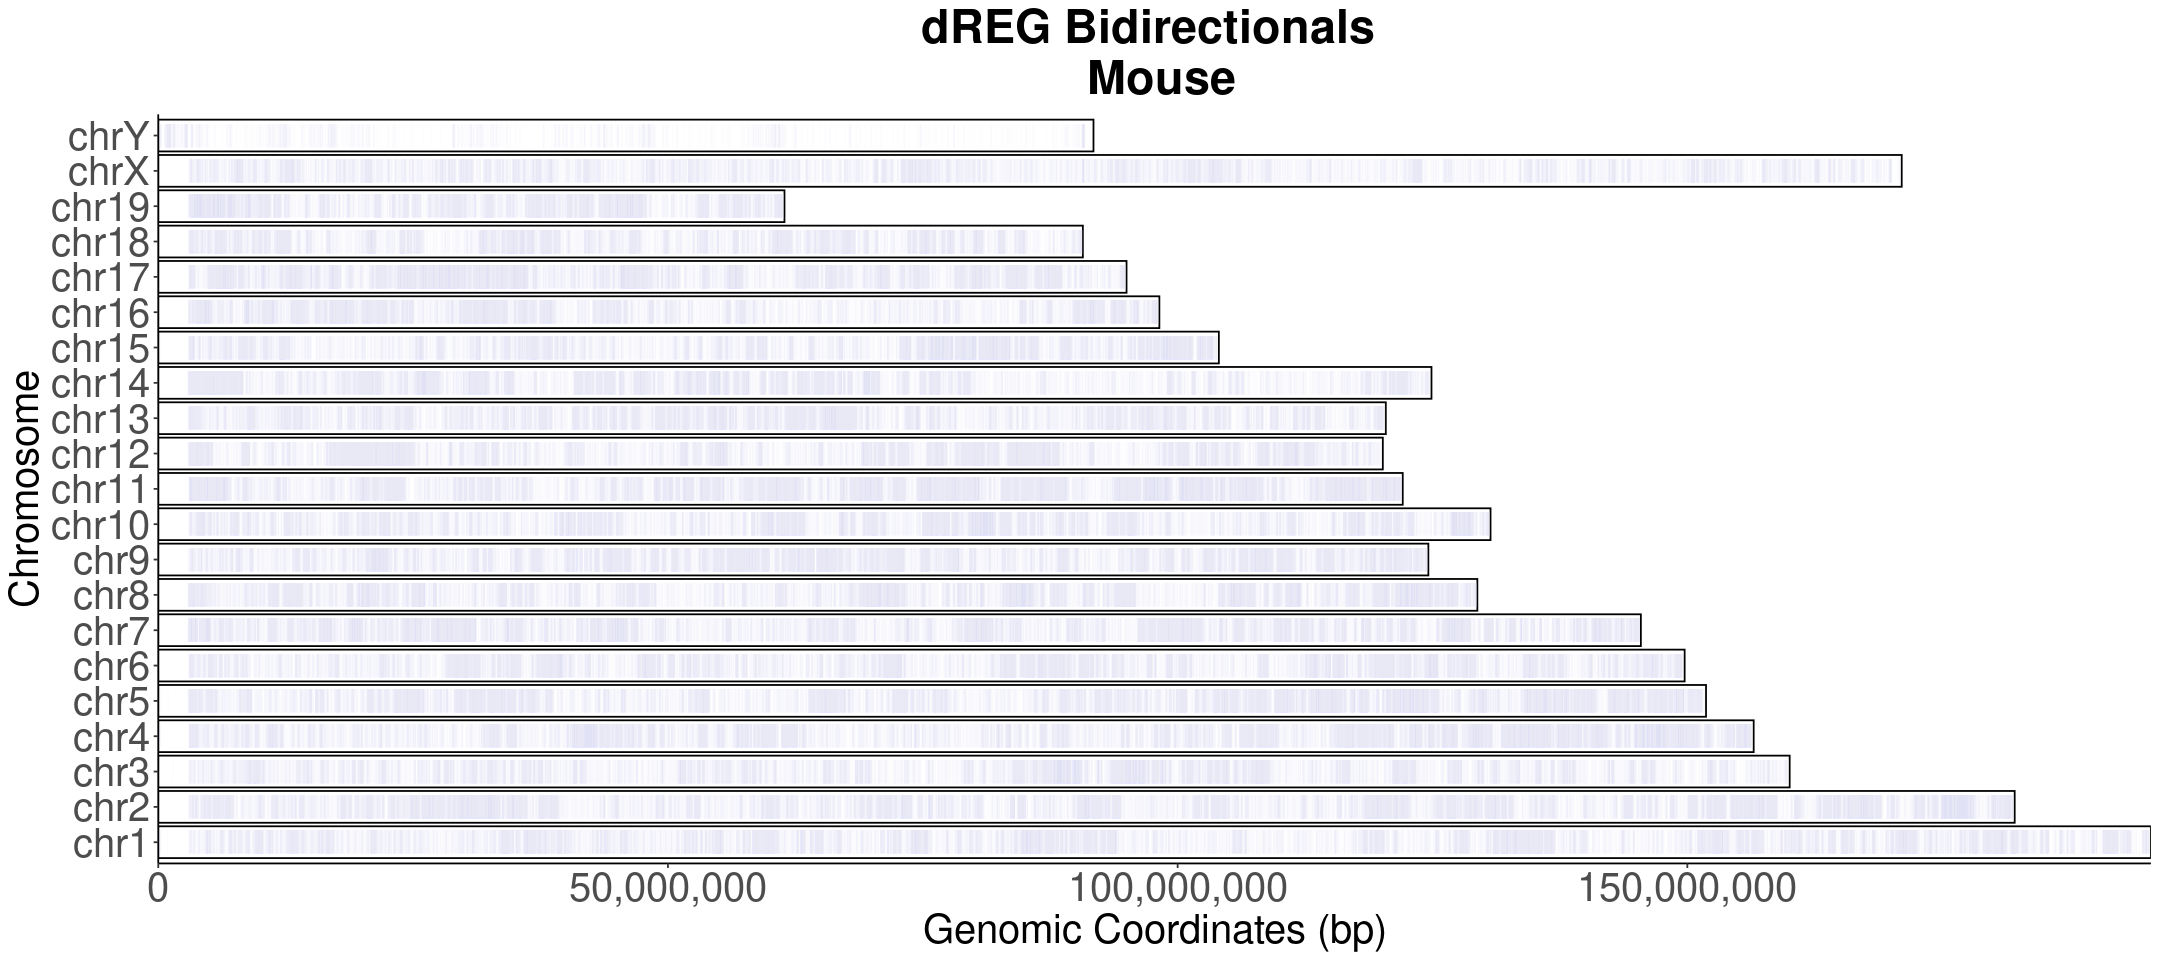

In [50]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_dreg_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = subset(mm10_bidirs, V4=="dreg"),
           aes(y = V1, x = V2), 
           shape=124, 
           color='#d8daeb',#'#d01c8b',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("dREG Bidirectionals \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_dreg_plot

In [51]:
ggsave(mm10_dreg_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_dreg_genome.png", 
       bg = "transparent")

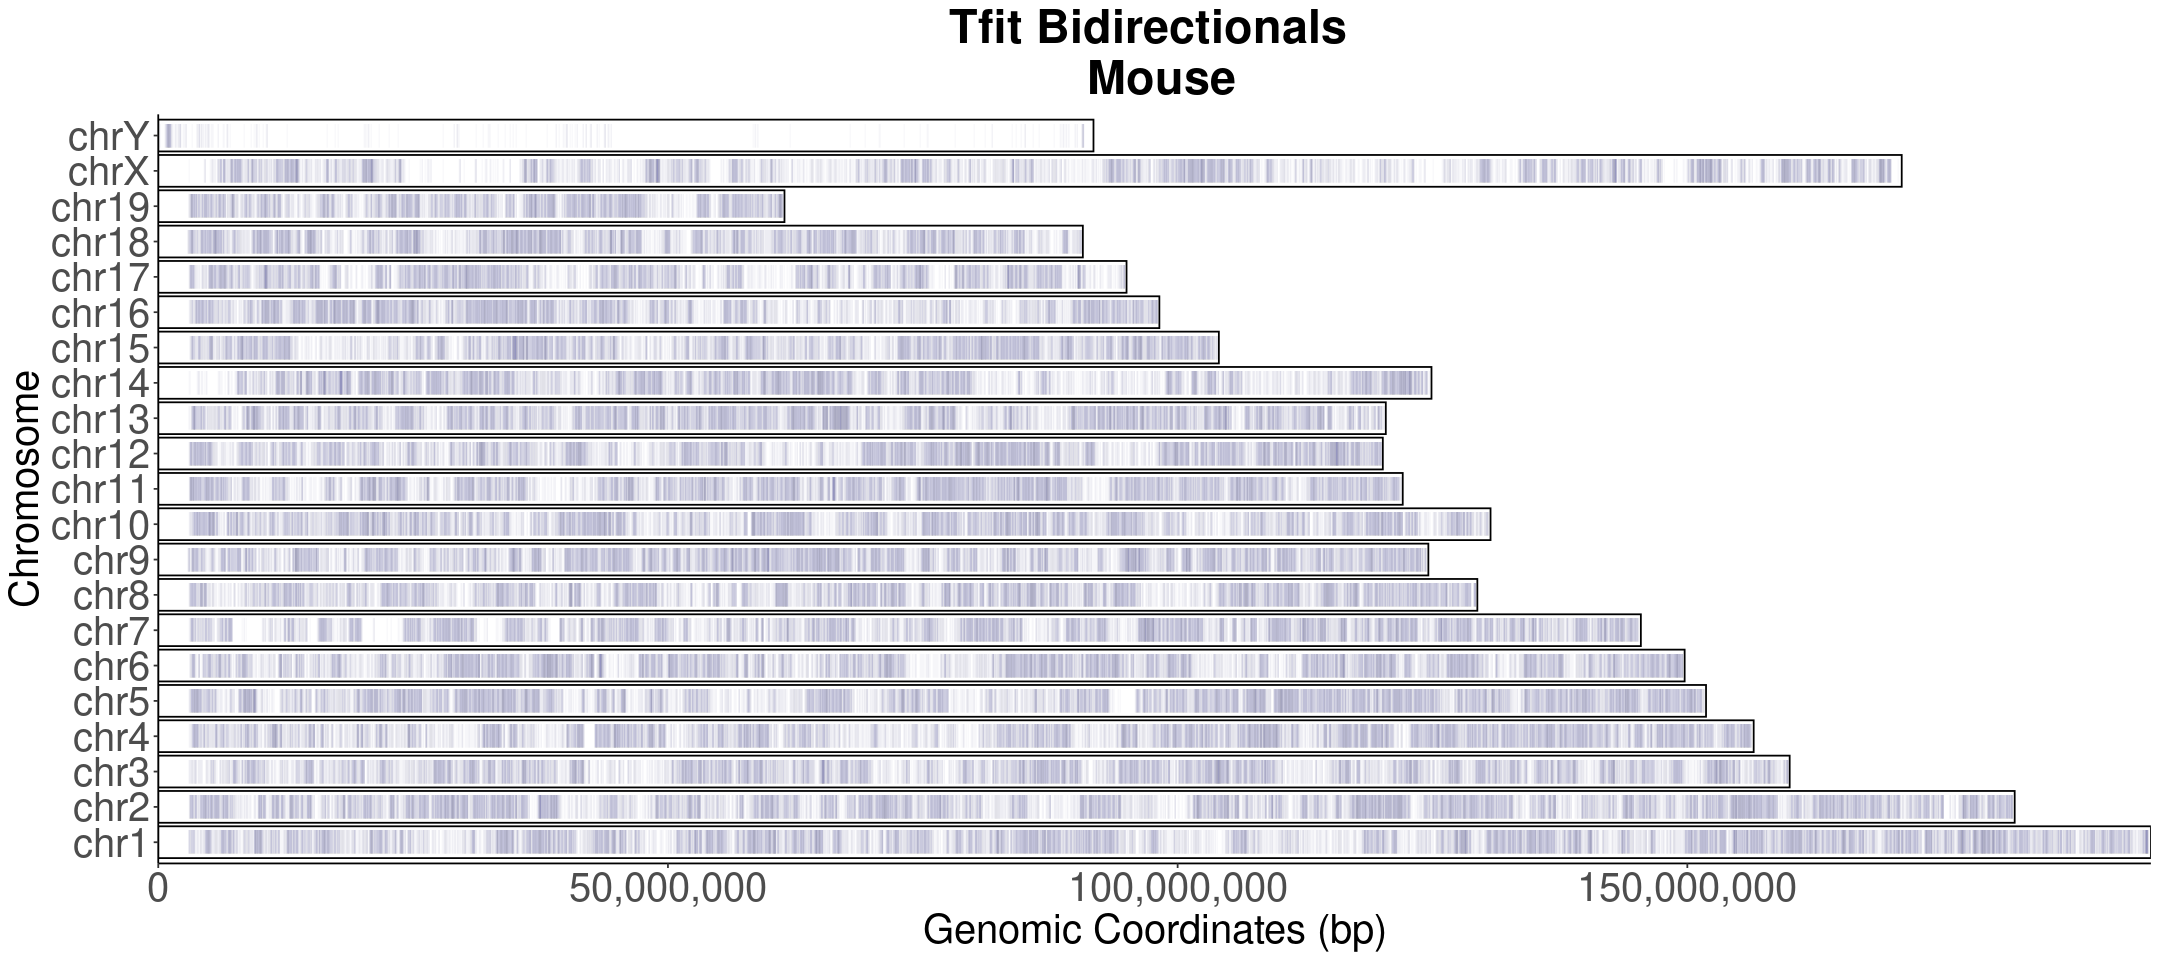

In [52]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_tfit_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = subset(mm10_bidirs, V4=="tfit"),
           aes(y = V1, x = V2), 
           shape=124, 
           color='#998ec3',#'#4dac26',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit Bidirectionals \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_tfit_plot

In [53]:
ggsave(mm10_tfit_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_tfit_genome.png", 
       bg = "transparent")

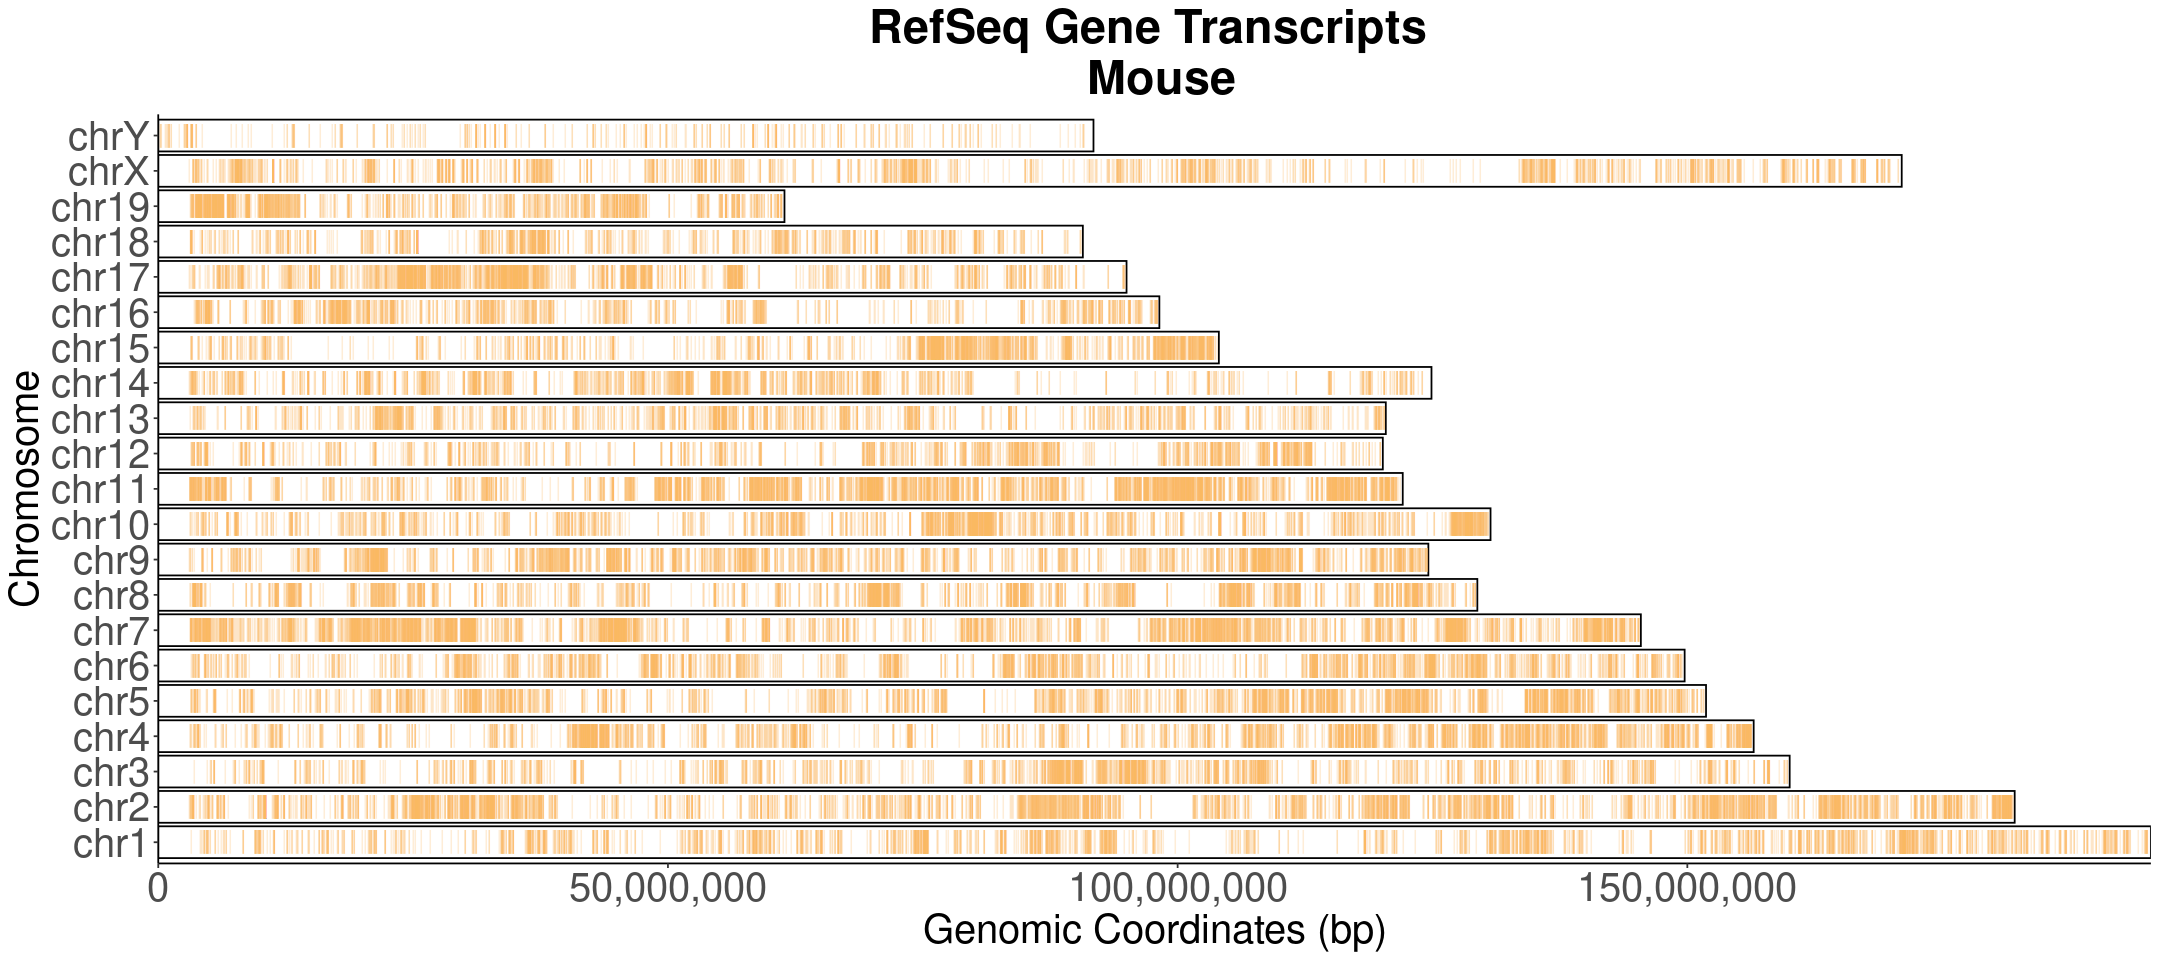

In [54]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_refseq_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = mm10_refseq_chr,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#fdb863',#'gray40',
           size=5, 
           alpha=0.25) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
#ggtitle("Tfit Bidirectionals \n mm10 RefSeq Gene Transcripts") +
ggtitle("RefSeq Gene Transcripts \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_refseq_plot

In [55]:
ggsave(mm10_refseq_plot, width = 18, height = 8,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_refseq_genome.png", 
       bg = "transparent")

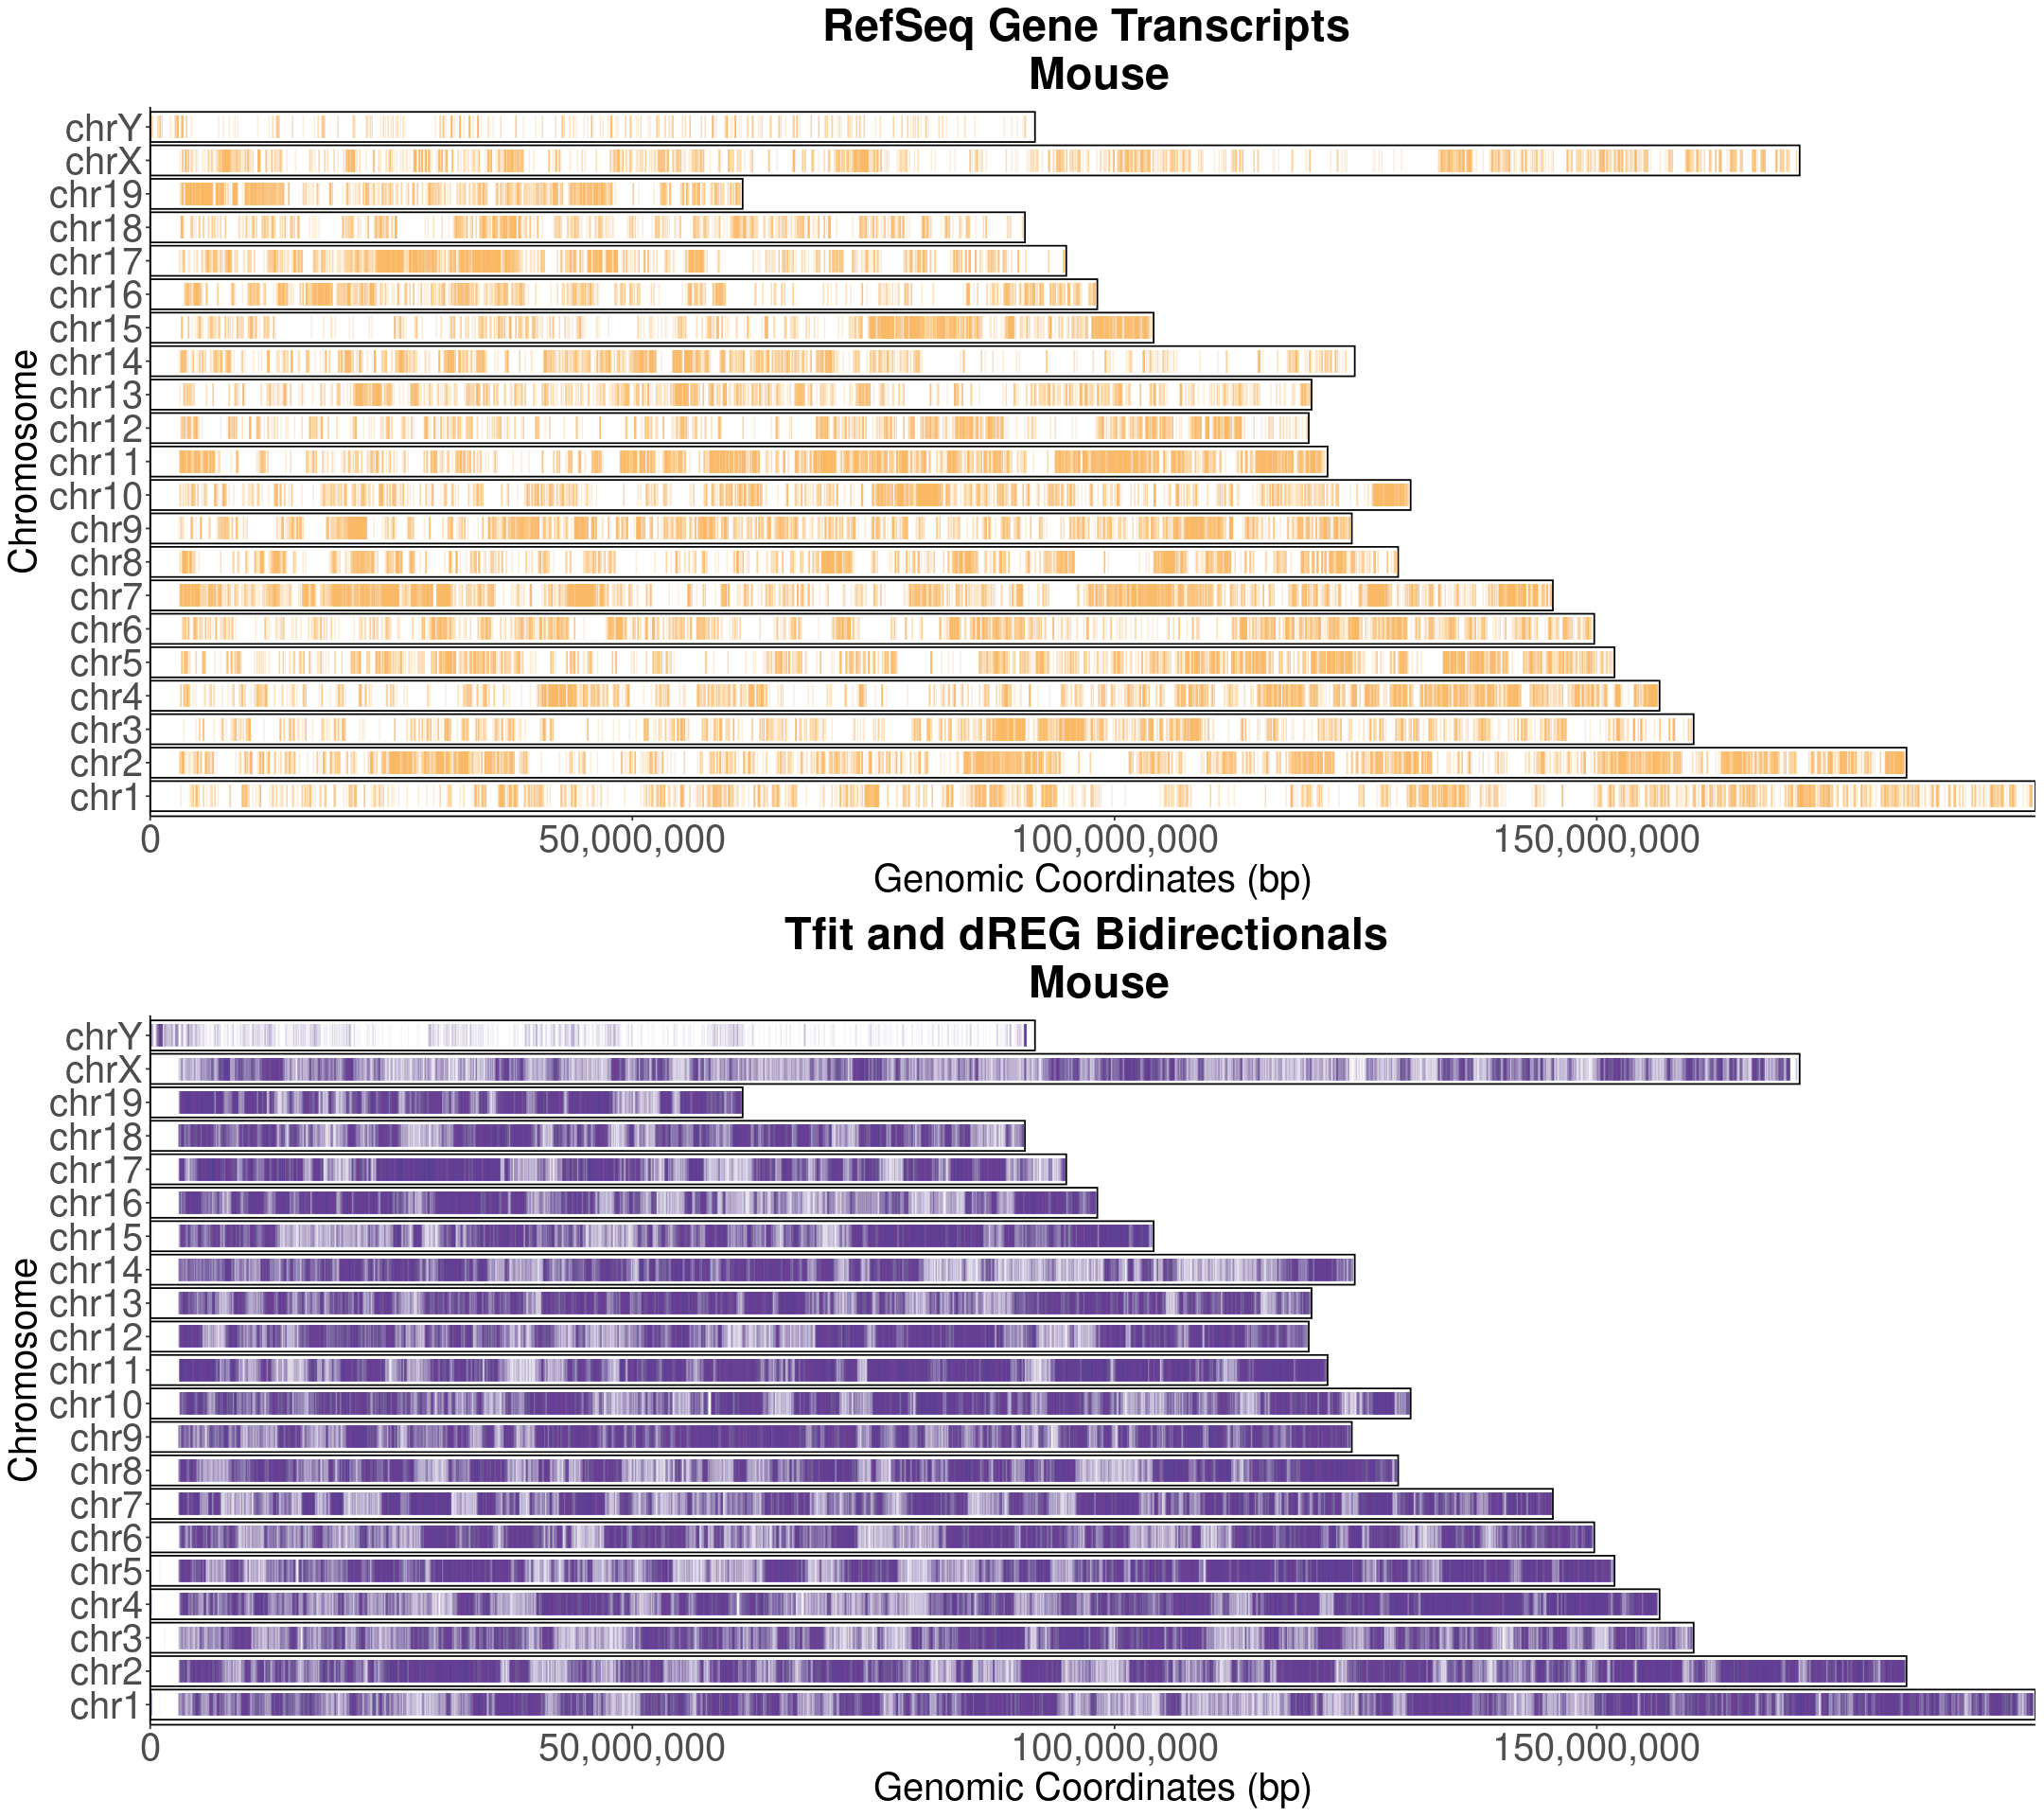

In [59]:
options(repr.plot.width=18, repr.plot.height=16)
mm10_refseq_bidirs_plot <- cowplot::plot_grid(mm10_refseq_plot,
                                              mm10_bidirs_plot,
                                              ncol = 1)
mm10_refseq_bidirs_plot

In [60]:
ggsave(mm10_refseq_bidirs_plot, width = 18, height = 16,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_refseq_bidirs_genome.png", 
       bg = "transparent")

# Session Information

In [61]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] stringr_1.4.1       purrr_0.3.4         UpSetR_1.4.0       
 [4] ComplexUpset_1.3.3  extrafont_0.18      VennDiagram_1.7.3  
 [7] futile.logger_1.4.3 ggvenn_0.1.9        epitools_0.5-10.1  
[10] RColorBrewer_1.1-3  scales_1.2.1        cowplot_1.1.1      
[13] ggplot2_3.3.6       R.utils_2.12.0      R.oo_1.25.0     